![lop](../../images/logo_diive1_128px.png)

<span style='font-size:40px; display:block;'>
<b>
    Flux Processing Chain
</b>
</br>
  
</span>
<p>Post-processing of EddyPro <i>_fluxnet_</i> output files</p>

---
**Notebook version**: `9.1` (4 Mar 2025)  
**Author**: Lukas Hörtnagl (holukas@ethz.ch)  

</br>

</br>

---

# **BACKGROUND**

---

- This notebook demonstrates part of the flux post-processing used for fluxes from Swiss FluxNet research stations
- For a description of the different flux levels, see [Flux Processing Chain](https://www.swissfluxnet.ethz.ch/index.php/data/ecosystem-fluxes/flux-processing-chain/)
- Flux calculations (Level-1) were done in a previous step
- This notebook uses the calculated fluxes (Level-1) and applies several post-processing steps:
    - Quality flag extension (Level-2)
    - Storage correction (Level-3.1)
    - Outlier removal (Level-3.2)
    - USTAR filtering (Level-3.3) - needs *known* thresholds from separate analysis, e.g. from FLUXNET
    - Gap-filling (Level-4.1) for flux using multiple methods ([MDS](../GapFilling/FluxMDSGapFilling.ipynb), [long-term random forest](../GapFilling/LongTermRandomForestGapFilling.ipynb))
- Other flux levels are currently not produced in this example:
    
    - NEE Partitioning (Level-4.2)
 
**Important**
- Flux variable names in the input files should follow the [FLUXNET convention](https://fluxnet.org/data/fluxnet2015-dataset/fullset-data-product/)

</br>

</br>

---

# **GENERAL SETTINGS**

---

## Flux variable
`FLUXVAR` is the name of the flux variable in the data files. In the EddyPro `_fluxnet_` output files, the flux variables we primarily use are:
  - `FC` ... CO2 flux, becomes `NEE` after storage correction (Level-3.1)
  - `LE` ... Latent heat flux (water)
  - `H` ... Sensible heat flux
  - `FN2O` ... Nitrous oxide flux
  - `FCH4` ... Methane flux
  
There are more flux variables in the output file, but we rarely need them:
  - `FH2O` ... H2O flux, very important but it is the same as `ET` and `LE` but with different units
  - `ET` ... Evapotranspiration, very important but it is the same as `FH2O` and `LE` but with different units. We can easily calculte `ET` later from `LE`, e.g. in `ReddyProc`.
  - `TAU` ... Momentum flux, a measure of the turbulent transfer of momentum between the land surface and the atmosphere

Set the name of the flux variable in the output file(s), must use the FLUXNET naming convention, e.g. FC, FH2O, LE, ET, H, FN2O, FCH4:

In [1]:
FLUXVAR = "FC"

## Site location
- Latitude and longitude of the site where data were recorded. This info is mainly used to calculate potential radiation, which is then used to divide the dataset into daytime and nighttime data.
- UTC offset of the timestamp used in the dataset, important for calculating potential radiation for this location with the correct timestamp.

In [2]:
SITE_LAT = 47.478333   # CH-LAE
SITE_LON = 8.364389  # CH-LAE
UTC_OFFSET = 1  # Time stamp offset in relation to UTC, e.g. 1 for UTC+01:00 (CET), important for the calculation of potential radiation for detecting daytime and nighttime

## Daytime/nighttime
- Threshold for potential radiation in `W m-2`, records below threshold are considered nighttime

In [3]:
NIGHTTIME_THRESHOLD = 20

## Quality requirements
- The default setting is to accept highest-quality and medium-quality fluxes for daytime (overall quality flag `QCF` = 0 or 1), and highest-quality fluxes only for nighttime (flag `QCF` = 0)
- `DAYTIME_ACCEPT_QCF_BELOW = 2` accepts high- (`QCF=0`) and medium-quality (`QCF=1`) fluxes for *daytime*, rejects low-quality (`QCF=2`) fluxes
- `NIGHTTIMETIME_ACCEPT_QCF_BELOW = 1` accepts high-quality (`QCF=0`) fluxes for *nighttime*, rejects medium-quality (`QCF=1`) and low-quality (`QCF=2`) fluxes
- This strict quality-filtering removes a lot of data points during nighttime

In [4]:
DAYTIME_ACCEPT_QCF_BELOW = 2
NIGHTTIMETIME_ACCEPT_QCF_BELOW = 1

</br>

---

# **IMPORTS**

---

- This notebook uses `diive` ([source code](https://github.com/holukas/diive)) to check eddy covariance fluxes for quality

In [5]:
import importlib.metadata
import warnings
from datetime import datetime
from pathlib import Path

import matplotlib.pyplot as plt
import pandas as pd
import scipy.stats
import seaborn as sns

from diive.core.dfun.stats import sstats  # Time series stats
from diive.core.io.files import save_parquet, load_parquet
from diive.core.plotting.timeseries import TimeSeries  # For simple (interactive) time series plotting
from diive.pkgs.flux.hqflux import analyze_highest_quality_flux
from diive.pkgs.fluxprocessingchain.fluxprocessingchain import FluxProcessingChain
from diive.pkgs.fluxprocessingchain.fluxprocessingchain import LoadEddyProOutputFiles

warnings.filterwarnings(action='ignore', category=FutureWarning)
warnings.filterwarnings(action='ignore', category=UserWarning)
version_diive = importlib.metadata.version("diive")
print(f"diive version: v{version_diive}")

diive version: v0.87.1


</br>

</br>

---

# **DOCSTRING** for `FluxProcessingChain`

---

In [6]:
# help(FluxProcessingChain)

</br>

</br>

---

# **LOAD DATA** (2 options)

---

- It is possible to load data from (multiple) EddyPro _fluxnet_ output files (data from files will be merged), or directly from one single [parquet](https://parquet.apache.org/) file.
- parquet files are a good option for large datasets because they load and save much faster than when using conventional CSV files.
- For large datasets, it makes sense to first load and merge data from the original EddyPro _fluxnet_ output files, then convert the merged data to one single parquet file and then use this file as input file.

</br>

## Option 1: Load data from single or multiple EddyPro *_fluxnet_* output files
- Used to read data from the EddyPro _fluxnet_ output files
- Found files will be merged together into one single dataframe (`maindf`)

If you want to search for EddyPro _fluxnet_ files in specific locations, you can specify multiple folders here:

In [7]:
# # Folder(s) where input file(s) are located
# SOURCEDIRS = [r'example_data/']  

In [8]:
# ep = LoadEddyProOutputFiles(sourcedir=SOURCEDIRS, filetype='EDDYPRO-FLUXNET-CSV-30MIN')
# ep.searchfiles()
# ep.loadfiles()
# maindf = ep.maindf
# metadata = ep.metadata

</br>

## Option 2: Load data from `parquet` file
- Can be used to continue a previous session where another flux variable was already post-processed
- For example, if you have already post-processed CO2 flux and now want to post-process H2O flux
- Also detects time resolution of time series, this info was lost when saving to the parquet file

If you want to load data directly from a specific parquet file, you can specify its name and location here:

In [9]:
SOURCEDIR = r""
FILENAME = r"03.2_FC_OPENLAG_EDDYPRO_FLUXNET_OUTPUT_IRGA72_2016-2024.parquet"
FILEPATH = Path(SOURCEDIR) / FILENAME
print(f"Data will be loaded from the following file:\n{FILEPATH}")

Data will be loaded from the following file:
03.2_FC_OPENLAG_EDDYPRO_FLUXNET_OUTPUT_IRGA72_2016-2024.parquet


In [10]:
maindf = load_parquet(filepath=FILEPATH)

Loaded .parquet file 03.2_FC_OPENLAG_EDDYPRO_FLUXNET_OUTPUT_IRGA72_2016-2024.parquet (0.214 seconds).
    --> Detected time resolution of <30 * Minutes> / 30min 


</br>

## Option 3: Load example data

In [11]:
# from diive.configs.exampledata import load_exampledata_EDDYPRO_FLUXNET_CSV_30MIN
# maindf, metadata = load_exampledata_EDDYPRO_FLUXNET_CSV_30MIN()

</br>

## (Optional) Restrict data to time range

In [12]:
# Restrict data range
maindf = maindf.loc[(maindf.index.year >= 2017) & (maindf.index.year <= 2024)].copy()

</br>

## Check data

In [13]:
display(maindf.head(3))
display(maindf.tail(3))
display(sstats(maindf[FLUXVAR]))

AIR_CP  AIR_DENSITY    AIR_MV  AIR_RHO_CP  AOA_METHOD  AXES_ROTATION_METHOD  ...  SW_IN_T1_47_1_gfXG  TA_T1_47_1_gfXG  PPFD_IN_T1_47_1_gfXG  VPD_T1_47_1  VPD_T1_47_1_gfXG  FLAG_VPD_T1_47_1_gfXG_ISFILLED
TIMESTAMP_MIDDLE                                                                                   ...                                                                                                                          
2017-01-01 00:15:00  1007.20      1.16100  0.024942     1169.36         0.0                   1.0  ...                 0.0        -5.089633                   0.0     0.000566          0.000566                               0
2017-01-01 00:45:00  1007.18      1.16086  0.024945     1169.19         0.0                   1.0  ...                 0.0        -5.140866                   0.0     0.000563          0.000563                               0
2017-01-01 01:15:00  1007.12      1.16529  0.024851     1173.58         0.0                   1.0  ...                 0.0        -5.393694                   0.0     0.000553          0.000553                               0

[3 rows x 507 columns]

AIR_CP  AIR_DENSITY    AIR_MV  AIR_RHO_CP  AOA_METHOD  AXES_ROTATION_METHOD  ...  SW_IN_T1_47_1_gfXG  TA_T1_47_1_gfXG  PPFD_IN_T1_47_1_gfXG  VPD_T1_47_1  VPD_T1_47_1_gfXG  FLAG_VPD_T1_47_1_gfXG_ISFILLED
TIMESTAMP_MIDDLE                                                                                   ...                                                                                                                          
2024-12-31 22:45:00  1007.82      1.14946  0.025191     1158.44         0.0                   1.0  ...                 0.0        -0.392922                   0.0     0.060608          0.060608                               0
2024-12-31 23:15:00  1007.71      1.14668  0.025253     1155.52         0.0                   1.0  ...                 0.0         0.792661                   0.0     0.117695          0.117695                               0
2024-12-31 23:45:00  1007.78      1.15011  0.025177     1159.05         0.0                   1.0  ...                 0.0        -0.422600                   0.0     0.069221          0.069221                               0

[3 rows x 507 columns]

FC
STARTDATE       2017-01-01 00:15
ENDDATE         2024-12-31 23:45
PERIOD        2921 days 23:30:00
NOV                       128967
MISSING                    11289
MISSING_PERC            8.048854
MEAN                   -0.843326
MEDIAN                  0.216977
SD                     16.677658
VAR                   278.144261
SD/MEAN               -19.776044
SUM               -108761.262433
MIN                      -1223.5
MAX                      1112.36
P01                   -32.515296
P05                    -19.42459
P25                    -4.023365
P75                      2.81519
P95                     12.36515
P99                    37.772186

In [14]:
# maindf['VPD_T1_47_1'].describe()

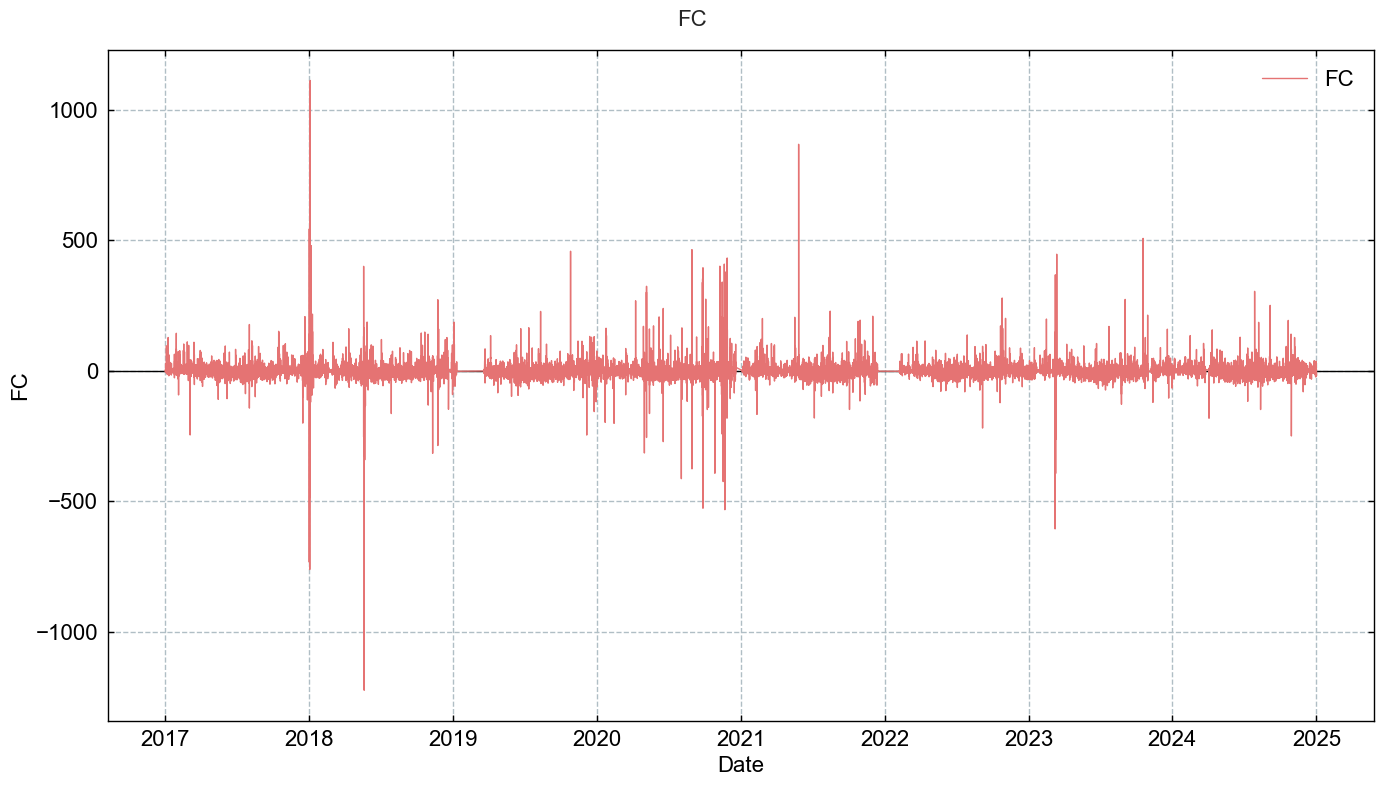

In [15]:
# TimeSeries(series=maindf[FLUXVAR]).plot_interactive()
TimeSeries(series=maindf[FLUXVAR]).plot()

</br>

</br>

---

# **START FLUX PROCESSING CHAIN**

---

- First we need to initialize the processing chain by providing some basic info.
- At the same time, some fundamental variables are also created: potential radiation, and two flags based on it: daytime flag (1=daytime) and nighttime flag (1=nighttime).

In [16]:
fpc = FluxProcessingChain(
    df=maindf,
    fluxcol=FLUXVAR,
    site_lat=SITE_LAT,
    site_lon=SITE_LON,
    utc_offset=UTC_OFFSET,    
    nighttime_threshold=NIGHTTIME_THRESHOLD,
    daytime_accept_qcf_below=DAYTIME_ACCEPT_QCF_BELOW,
    nighttimetime_accept_qcf_below=NIGHTTIMETIME_ACCEPT_QCF_BELOW
)

Detected base variable CO2 for FC. (CO2 was used to calculate FC.)
Calculated potential radiation from latitude and longitude (SW_IN_POT) ... 
Calculated daytime flag DAYTIME and nighttime flag NIGHTTIME from SW_IN_POT ...
++ Added new column SW_IN_POT to input data.  (!) Existing SW_IN_POT in input data is overwritten.
++ Added new column DAYTIME to input data.
++ Added new column NIGHTTIME to input data.


- Let's check the flux processing chain dataframe: this are the data the chain is working with in this run:

In [17]:
fpc.fpc_df

FC     USTAR  SW_IN_POT  DAYTIME  NIGHTTIME
TIMESTAMP_MIDDLE                                                       
2017-01-01 00:15:00   2.321600  0.119926        0.0      0.0        1.0
2017-01-01 00:45:00   2.153140  0.088974        0.0      0.0        1.0
2017-01-01 01:15:00   4.381530  0.219446        0.0      0.0        1.0
2017-01-01 01:45:00   0.582897  0.158594        0.0      0.0        1.0
2017-01-01 02:15:00   0.607510  0.169269        0.0      0.0        1.0
...                        ...       ...        ...      ...        ...
2024-12-31 21:45:00  -3.929310  0.245204        0.0      0.0        1.0
2024-12-31 22:15:00  -8.797730  0.388422        0.0      0.0        1.0
2024-12-31 22:45:00  -6.486530  0.532218        0.0      0.0        1.0
2024-12-31 23:15:00 -19.688700  0.590691        0.0      0.0        1.0
2024-12-31 23:45:00   6.390400  0.460941        0.0      0.0        1.0

[140256 rows x 5 columns]

</br>

</br>

---

# Level-2: **QUALITY FLAG EXTENSION**

---

> Extract additional quality information from the EddyPro output and store it in newly added quality flags.



Note that the USTAR filtering is not part of the Level-2 calculations.

</br>

## User settings
- A test for missing values is always included: flag calculated here from missing flux values in the EddyPro output file

</br>

### SSITC tests (default: `True`)
- Flag calculated in EddyPro
- Combination of the two partial tests *steady state test* and *developed turbulent conditions test*
- This notebook expects the SSITC flag to follow the flagging policy according to Mauder and Foken 2004:
    - `0` for best quality fluxes
    - `1` for fluxes suitable for general analysis such as annual budgets (although this is debatable for nighttime data)
    - `2` for fluxes that should be discarded from the dataset

In [18]:
TEST_SSITC = True  # Default True
TEST_SSITC_SETFLAG_TIMEPERIOD = {2: [[1, '2022-05-01', '2023-09-30']]}

</br>

### Flux base variable completeness test (default: `True`)
- Flag newly calculated here
- Check completeness of the variable that was used to calculate the respective flux
- Example: `CO2` is the base variable that was used to calculate flux `FC`, the test is therefore run on `CO2`
- Checks number of records of the relevant base variable available for each averaging Interval and calculates completeness flag as follows:
    - `0` for files where >= 99% of base variable are available
    - `1` for files where >= 97% and < 99% of base variable are available
    - `2` for files where < 97% of base variable are available
 
List of flux base variables and the corresponding fluxes:
- `CO2`: used to calculate `FC`
- `H2O`: used to calculate `FH2O`
- `H2O`: used to calculate `LE`
- `H2O`: used to calculate `ET`
- `T_SONIC`: used to calculate `H`
- `N2O`: used to calculate `FN2O`
- `CH4`: used to calculate `FCH4`

In [19]:
TEST_GAS_COMPLETENESS = False  # Default True

</br>

### Spectral correction factor test (default: `True`)
- Flag calculated here from the gas `SCF` variable in EddyPro output file

In [20]:
TEST_SPECTRAL_CORRECTION_FACTOR = True  # Default True

</br>

### Signal strength test

<div class="alert alert-block alert-info">
<b>Always recommended if flux was calculated using a gas analyzer.</b>
</div>  

<div class="alert alert-block alert-danger">
<b>Do not use for H (sensible heat flux).</b> This test is only relevant for fluxes where the concentration/temperature was measured by a gas analyzer, e.g. FC, FH2O, LE, ET, N2O, CH4, etc ... 
</div>  

- Signal strength / AGC / window dirtiness test (if available)
- Flag calculated here from the signal strength / AGC variable for the gas analyzer in EddyPro output file
- `SIGNAL_STRENGTH_COL`: Name of the column storing the signal strength, typically 'CUSTOM_AGC_MEAN' for LI-7500, 'CUSTOM_SIGNAL_STRENGTH_IRGA72_MEAN' for LI-7200, or something similar
- `SIGNAL_STRENGTH_THRESHOLD`: Signal strength threshold, flux values where threshold is exceeded are flagged as rejected
- `SIGNAL_STRENGTH_METHOD`: `discard above` flags fluxes where signal strength > threshold, `discard below` where signal strength < threshold

In [21]:
# Signal strength
TEST_SIGNAL_STRENGTH = True
TEST_SIGNAL_STRENGTH_COL = 'CUSTOM_SIGNAL_STRENGTH_IRGA72_MEAN'  # Typical variable name in fluxnet files
TEST_SIGNAL_STRENGTH_METHOD = 'discard below'
TEST_SIGNAL_STRENGTH_THRESHOLD = 50

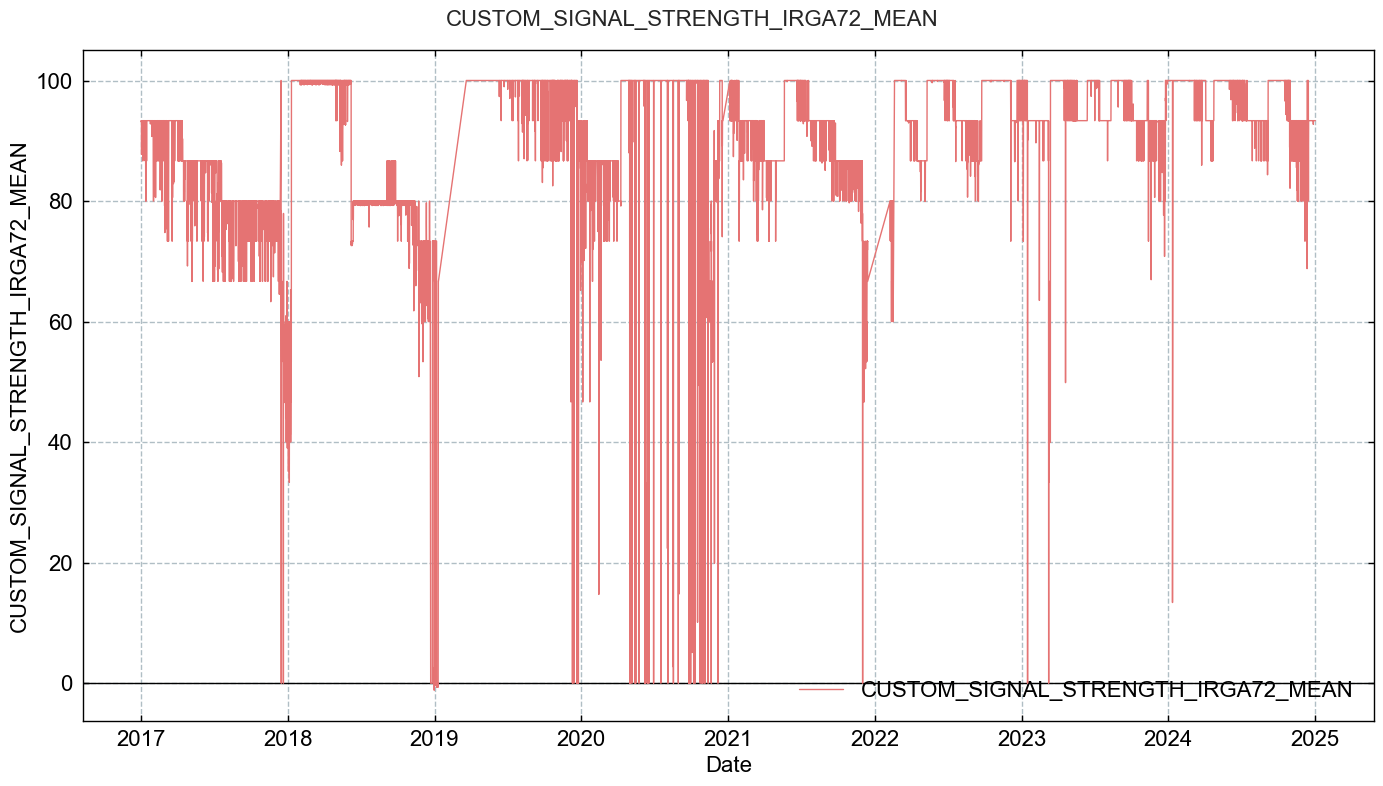

In [22]:
# TimeSeries(series=df_orig[SIGNAL_STRENGTH_COL]).plot_interactive()
TimeSeries(series=maindf[TEST_SIGNAL_STRENGTH_COL]).plot()

In [23]:
# [print(c) for c in maindf.columns if "SIGNAL" in c]

</br>

### Raw data screening tests
- Flags were calculated in EddyPro
- See here for more details: [Despiking and raw data statistical screening (EddyPro help)](https://www.licor.com/env/support/EddyPro/topics/despiking-raw-statistical-screening.html)

In [24]:
TEST_RAWDATA = True  # Default True
TEST_RAWDATA_SPIKES = True  # Default True
TEST_RAWDATA_AMPLITUDE = False  # Default True
TEST_RAWDATA_DROPOUT = True  # Default True
TEST_RAWDATA_ABSLIM = False  # Default False
TEST_RAWDATA_SKEWKURT_HF = False  # Default False
TEST_RAWDATA_SKEWKURT_SF = False  # Default False
TEST_RAWDATA_DISCONT_HF = False  # Default False
TEST_RAWDATA_DISCONT_SF = False  # Default False

</br>

### Angle-of-attack test (default: `False`)
> This test calculates sample-wise Angle of Attacks throughout the current flux averaging period, and flags it if the percentage of angles of attack exceeding a user-defined range is beyond a (user-defined) threshold.  
> Source: [EddyPro help](https://www.licor.com/env/support/EddyPro/topics/despiking-raw-statistical-screening.html?Highlight=angle%20of%20attack#Angleofattack)  *(3 Jan 2024)*
- Flag was calculated in EddyPro
- Flag can be useful during some time periods when the sonic anemometer had issues
- Not used by default (similar to ICOS)

In [25]:
TEST_RAWDATA_ANGLE_OF_ATTACK = False  # Default False
# TEST_RAWDATA_ANGLE_OF_ATTACK_APPLICATION_DATES = []
TEST_RAWDATA_ANGLE_OF_ATTACK_APPLICATION_DATES = [['2008-01-01', '2010-01-01'],
                                                  ['2016-03-01', '2016-05-01'],
                                                  ['2021-12-10', '2021-12-23']]

</br>

### Steadiness of horizontal wind test (default: `False`)
> This test assesses whether the along-wind and crosswind components of the wind vector undergo a systematic reduction (or increase) throughout the file. If the quadratic combination of such systematic variations is beyond the user-selected limit, the flux averaging period is hard-flagged for instationary horizontal wind (Vickers and Mahrt, 1997, Par. 6g).  
> Source: [EddyPro help](https://www.licor.com/env/support/EddyPro/topics/despiking-raw-statistical-screening.html?Highlight=angle%20of%20attack#Steadinessofhorizontalwind)  *(3 Jan 2024)*
- Flag was calculated in EddyPro

In [26]:
TEST_RAWDATA_STEADINESS_OF_HORIZONTAL_WIND = False  # Default False

</br>

</br>

## Run

In [27]:
LEVEL2_SETTINGS = {
    'signal_strength': {
        'apply': TEST_SIGNAL_STRENGTH,
        'signal_strength_col': TEST_SIGNAL_STRENGTH_COL,
        'method': TEST_SIGNAL_STRENGTH_METHOD,
        'threshold': TEST_SIGNAL_STRENGTH_THRESHOLD},
    'raw_data_screening_vm97': {
        'apply': TEST_RAWDATA,
        'spikes': TEST_RAWDATA_SPIKES,
        'amplitude': TEST_RAWDATA_AMPLITUDE,
        'dropout': TEST_RAWDATA_DROPOUT,
        'abslim': TEST_RAWDATA_ABSLIM,
        'skewkurt_hf': TEST_RAWDATA_SKEWKURT_HF,
        'skewkurt_sf': TEST_RAWDATA_SKEWKURT_SF,
        'discont_hf': TEST_RAWDATA_DISCONT_HF,
        'discont_sf': TEST_RAWDATA_DISCONT_SF},
    'ssitc': {
        'apply': TEST_SSITC,
        'setflag_timeperiod': TEST_SSITC_SETFLAG_TIMEPERIOD},
    'gas_completeness': {
        'apply': TEST_GAS_COMPLETENESS},
    'spectral_correction_factor': {
        'apply': TEST_SPECTRAL_CORRECTION_FACTOR},
    'angle_of_attack': {
        'apply': TEST_RAWDATA_ANGLE_OF_ATTACK,
        'application_dates': TEST_RAWDATA_ANGLE_OF_ATTACK_APPLICATION_DATES},
    'steadiness_of_horizontal_wind': {
        'apply': TEST_RAWDATA_STEADINESS_OF_HORIZONTAL_WIND}
}
fpc.level2_quality_flag_expansion(**LEVEL2_SETTINGS)

[MissingValues]  running MissingValues ...
SSITC TEST: Generated new flag variable FLAG_L2_FC_SSITC_TEST, values taken from output variable FC_SSITC_TEST ...
    Flag FLAG_L2_FC_SSITC_TEST with value 1 was set to 2 between 2022-05-01 and 2023-09-30
SPECTRAL CORRECTION FACTOR TEST: Generating new flag variable FLAG_L2_FC_SCF_TEST, newly calculated from output variable FC_SCF, withflag 0 (good values) where FC_SCF < 2, flag 1 (ok values) where FC_SCF >= 2 and < 4, flag 2 (bad values) where FC_SCF >= 4...
SIGNAL STRENGTH TEST: Generating new flag variable FLAG_L2_FC_SIGNAL_STRENGTH_TEST, newly calculated from output variable CUSTOM_SIGNAL_STRENGTH_IRGA72_MEAN, with flag 0 (good values) where CUSTOM_SIGNAL_STRENGTH_IRGA72_MEAN >= 50, flag 2 (bad values) where CUSTOM_SIGNAL_STRENGTH_IRGA72_MEAN < 50 ...
RAW DATA TEST: Generated new flag variable FLAG_L2_FC_CO2_VM97_SPIKE_HF_TEST, values taken from output variable CO2_VM97_TEST from position 1, based on CO2, with flag 0 (good values) where t

</br>

</br>

## Finalize Level-2

In [28]:
fpc.finalize_level2()

++Added new column FLAG_L2_FC_MISSING_TEST.
++Added new column FLAG_L2_FC_SSITC_TEST.
++Added new column FLAG_L2_FC_SCF_TEST.
++Added new column FLAG_L2_FC_SIGNAL_STRENGTH_TEST.
++Added new column FLAG_L2_FC_CO2_VM97_SPIKE_HF_TEST.
++Added new column FLAG_L2_FC_CO2_VM97_DROPOUT_TEST.
++Added new column SUM_L2_FC_HARDFLAGS.
++Added new column SUM_L2_FC_SOFTFLAGS.
++Added new column SUM_L2_FC_FLAGS.
++Added new column FLAG_L2_FC_QCF.
++Added new column FC_L2_QCF.
++Added new column FC_L2_QCF0.


</br>

### Available `Level-2` variables
- This shows all available Level-2 variables for this flux

In [29]:
[x for x in fpc.fpc_df.columns if 'L2' in x]

['FLAG_L2_FC_MISSING_TEST',
 'FLAG_L2_FC_SSITC_TEST',
 'FLAG_L2_FC_SCF_TEST',
 'FLAG_L2_FC_SIGNAL_STRENGTH_TEST',
 'FLAG_L2_FC_CO2_VM97_SPIKE_HF_TEST',
 'FLAG_L2_FC_CO2_VM97_DROPOUT_TEST',
 'SUM_L2_FC_HARDFLAGS',
 'SUM_L2_FC_SOFTFLAGS',
 'SUM_L2_FC_FLAGS',
 'FLAG_L2_FC_QCF',
 'FC_L2_QCF',
 'FC_L2_QCF0']

</br>

### Plots

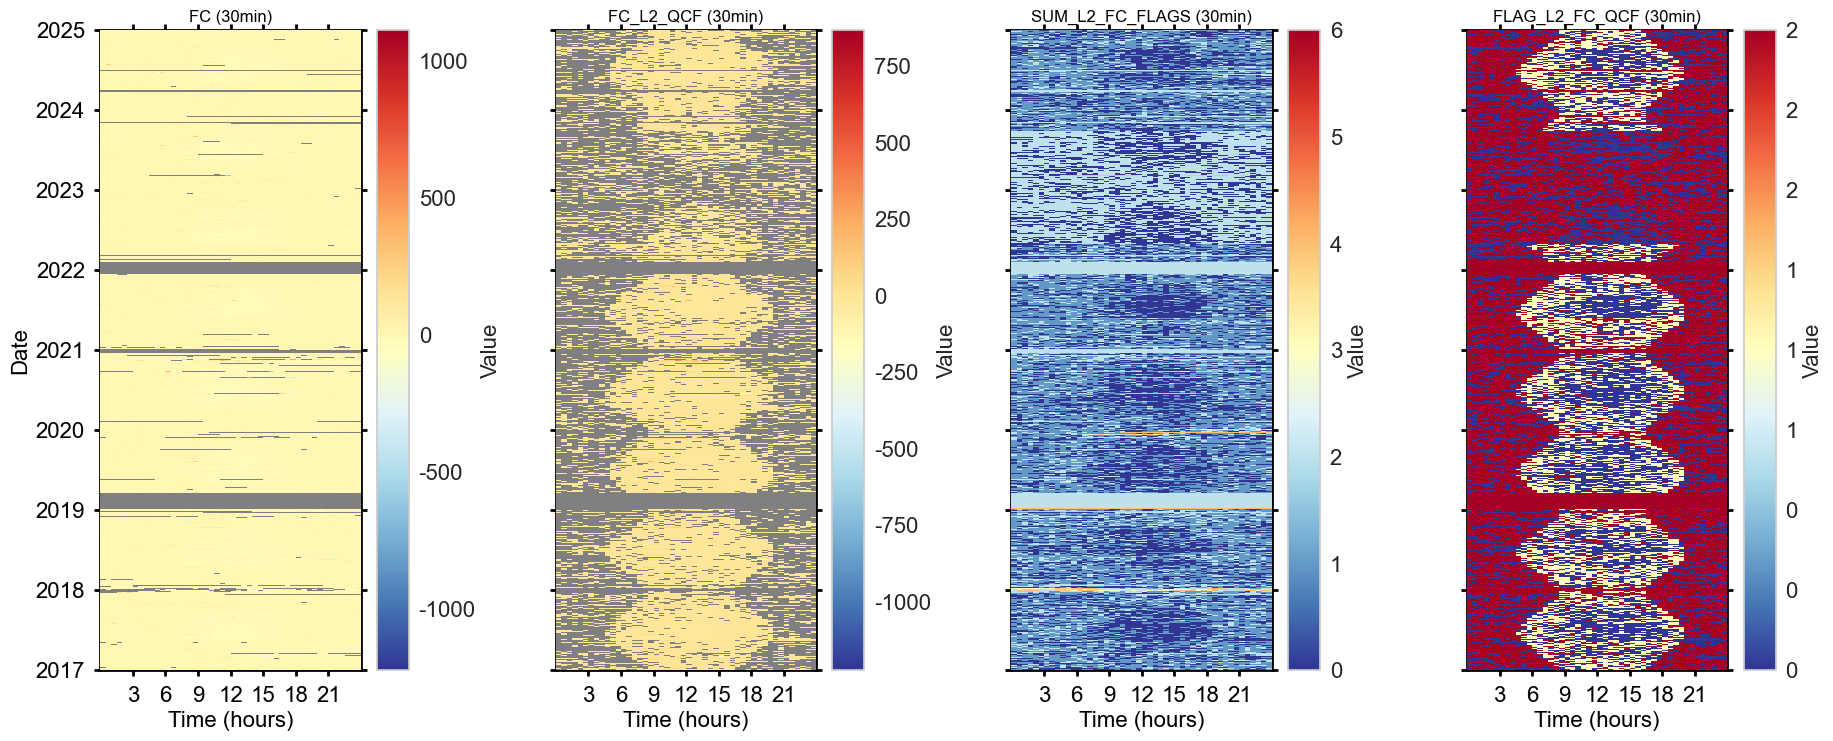

In [30]:
fpc.level2_qcf.showplot_qcf_heatmaps()

In [31]:
# fpc.level2_qcf.showplot_qcf_timeseries()

</br>

### Reports

In [32]:
fpc.level2_qcf.report_qcf_evolution()



QCF FLAG EVOLUTION
This output shows the evolution of the QCF overall quality flag
when test flags are applied sequentially to the variable FC.

Number of FC records before QC: 128967
+++ FLAG_L2_FC_MISSING_TEST rejected 0 values (+0.00%)      TOTALS: flag 0: 128967 (100.00%) / flag 1: 0 (0.00%) / flag 2: 0 (0.00%)
+++ FLAG_L2_FC_SSITC_TEST rejected 58965 values (+45.72%)      TOTALS: flag 0: 46234 (35.85%) / flag 1: 23768 (18.43%) / flag 2: 58965 (45.72%)
+++ FLAG_L2_FC_SCF_TEST rejected 0 values (+0.00%)      TOTALS: flag 0: 46234 (35.85%) / flag 1: 23768 (18.43%) / flag 2: 58965 (45.72%)
+++ FLAG_L2_FC_SIGNAL_STRENGTH_TEST rejected 146 values (+0.11%)      TOTALS: flag 0: 46167 (35.80%) / flag 1: 23689 (18.37%) / flag 2: 59111 (45.83%)
+++ FLAG_L2_FC_CO2_VM97_SPIKE_HF_TEST rejected 8 values (+0.01%)      TOTALS: flag 0: 46162 (35.79%) / flag 1: 23686 (18.37%) / flag 2: 59119 (45.84%)
+++ FLAG_L2_FC_CO2_VM97_DROPOUT_TEST rejected 0 values (+0.00%)      TOTALS: flag 0: 46162 (35.79%

In [33]:
fpc.level2_qcf.report_qcf_series()



SUMMARY: FLAG_L2_FC_QCF, QCF FLAG FOR FC
Between 2017-01-01 00:15 and 2024-12-31 23:45 ...
    Total flux records BEFORE quality checks: 128967 (91.95% of potential)
    Available flux records AFTER quality checks: 69848 (54.16% of total)
    Rejected flux records: 59119 (45.84% of total)
    Potential flux records: 140256
    Potential flux records missed: 11289 (8.05% of potential)



In [34]:
# fpc.level2_qcf.report_qcf_flags()

</br>

</br>

---

# Level-3.1: **STORAGE CORRECTION**

---

- The flux storage term (single point) is added to the flux
- For some records, the storage term can be missing. In such cases, missing terms are gap-filled using the rolling mean in an expanding window.
- Without gap-filling the storage term, we can lose an additional e.g. 2-3% of flux data

</br>

## Run

In [35]:
fpc.level31_storage_correction(gapfill_storage_term=True)

Detected storage variable SC_SINGLE for FC.
Calculating storage-corrected flux NEE_L3.1 from flux FC and storage term SC_SINGLE ...
Missing values for storage term SC_SINGLE_gfRMED_L3.1: 501
Gap-filling storage-term SC_SINGLE with rolling median (window size = 5 records, centered)  |  still missing values for storage term SC_SINGLE_gfRMED_L3.1: 391 ...
Gap-filling storage-term SC_SINGLE with rolling median (window size = 7 records, centered)  |  still missing values for storage term SC_SINGLE_gfRMED_L3.1: 124 ...
Gap-filling storage-term SC_SINGLE with rolling median (window size = 9 records, centered)  |  still missing values for storage term SC_SINGLE_gfRMED_L3.1: 98 ...
Gap-filling storage-term SC_SINGLE with rolling median (window size = 11 records, centered)  |  still missing values for storage term SC_SINGLE_gfRMED_L3.1: 71 ...
Gap-filling storage-term SC_SINGLE with rolling median (window size = 13 records, centered)  |  still missing values for storage term SC_SINGLE_gfRMED_L3.

</br>

## **Finalize Level-3.1**

In [36]:
fpc.finalize_level31()

++Added new column SC_SINGLE.
++Added new column SC_SINGLE_gfRMED_L3.1.
++Added new column FLAG_SC_SINGLE_gfRMED_L3.1_ISFILLED.
++Added new column NEE_L3.1.
++Added new column NEE_L3.1_QCF (Level-3.1 with applied quality flag from Level-2).
++Added new column NEE_L3.1_QCF0 (Level-3.1 with applied quality flag from Level-2).


</br>

### Available `Level-3.1` variables
- This shows all available Level-3.1 variables for this flux

In [37]:
[x for x in fpc.fpc_df.columns if 'L3.1' in x]

['SC_SINGLE_gfRMED_L3.1',
 'FLAG_SC_SINGLE_gfRMED_L3.1_ISFILLED',
 'NEE_L3.1',
 'NEE_L3.1_QCF',
 'NEE_L3.1_QCF0']

</br>

### Plots

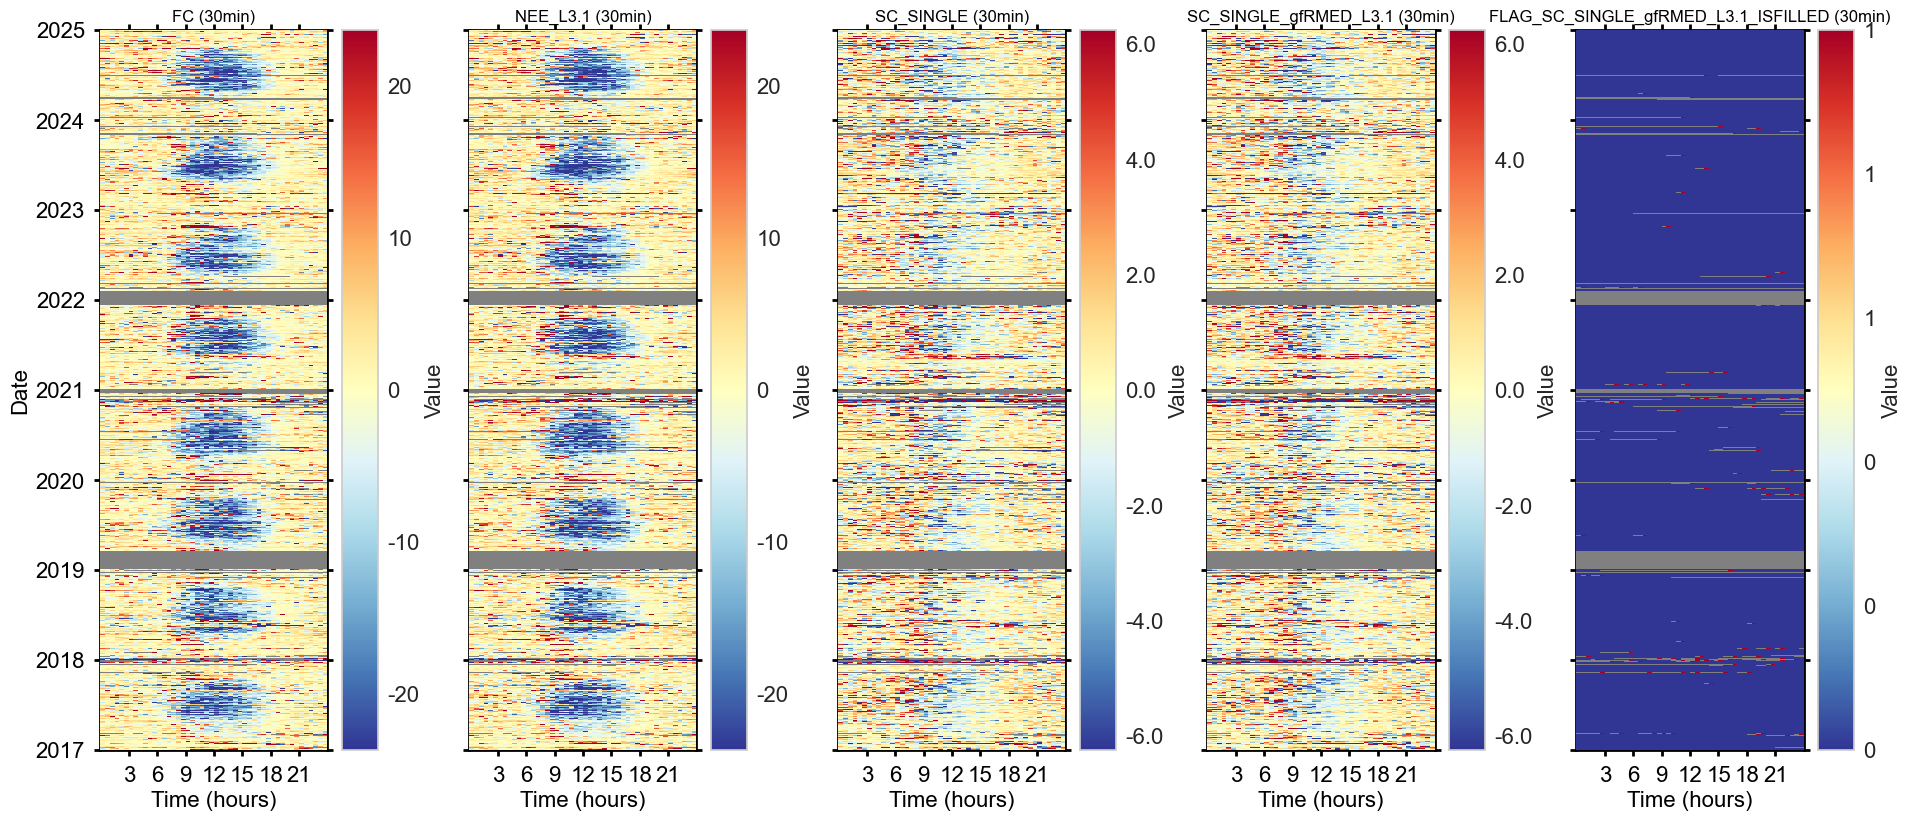

In [38]:
fpc.level31.showplot()

</br>

### Report

In [39]:
fpc.level31.report()


REPORT: STORAGE CORRECTION FOR FC
Swiss FluxNet processing chain, _L3.1: Storage Correction

The gap-filled storage term SC_SINGLE_gfRMED_L3.1 was added to flux FC.
The storage-corrected flux was stored as NEE_L3.1.

The flux was available for 128967 records (FC).
The original, non-gapfilled storage term was available for 128466 records (SC_SINGLE).
The original storage term SC_SINGLE was missing for 501 flux records.
Without gap-filling the storage term (SC_SINGLE), 501 measured flux records (FC) are lost.

For this run, gap-filling of SC_SINGLE was * SELECTED *.
After gap-filling the storage term, it was available for an additional 501 records (SC_SINGLE_gfRMED_L3.1).

In the storage-corrected flux NEE_L3.1 with 128967 records, 
  - 99.6% (128466 records) of used storage terms come from originally calculated data (SC_SINGLE)
  - 0.4% (501 records) of used storage terms come from gap-filled data (SC_SINGLE_gfRMED_L3.1)

Stats for gap-filled storage terms:
                       NOV  

</br>

---    

# Optional: **Analyze highest-quality flux** (so far)

---

- Analysis of fluxes after Level-3.1 where the overall quality flag `QCF` = 0
- This helps in understanding in what range the "true" flux occurs
- Here, the highest-quality fluxes are additionally filtered for outlier values using the relatively fast Local Outlier Factor test
- For this quick analysis, it is possible that the outlier test cuts off some "real" values that should be retained, but it nevertheless helps in understanding the flux range
- `QCF` = 0 is best quality, `QCF` = medium quality, `QCF` = 2 bad quality and always rejected
- The difference between quality 0 and quality 1 or 2 is huge


>>> Removing outliers from highest-quality DAYTIME fluxes (NEE_L3.1_QCF0)
>>> Outlier removal method: Local outlier factor across all data (n_neighbors=138, contamination=auto, repeat=False)
[LocalOutlierFactorAllData]  running LocalOutlierFactorAllData ...
ITERATION#1: Total found outliers: 117 values (daytime+nighttime)
>>> Largest non-outlier flux >= 0 DAYTIME:   81.29966999999999
>>> Smallest non-outlier flux >= 0 DAYTIME:  0.0009160000000000279
>>> Largest non-outlier flux < 0 DAYTIME:    -0.0010609999999999786
>>> Smallest non-outlier flux < 0 DAYTIME:   -44.11433
>>> Largest outlier flux >= 0 DAYTIME:   471.88469999999995
>>> Smallest outlier flux >= 0 DAYTIME:  81.997901
>>> Largest outlier flux < 0 DAYTIME:    -44.382470000000005
>>> Smallest outlier flux < 0 DAYTIME:   -139.46478000000002

>>> Removing outliers from highest-quality NIGHTTIME fluxes (NEE_L3.1_QCF0)
>>> Outlier removal method: Local outlier factor across all data (n_neighbors=92, contamination=auto, repeat=Fal

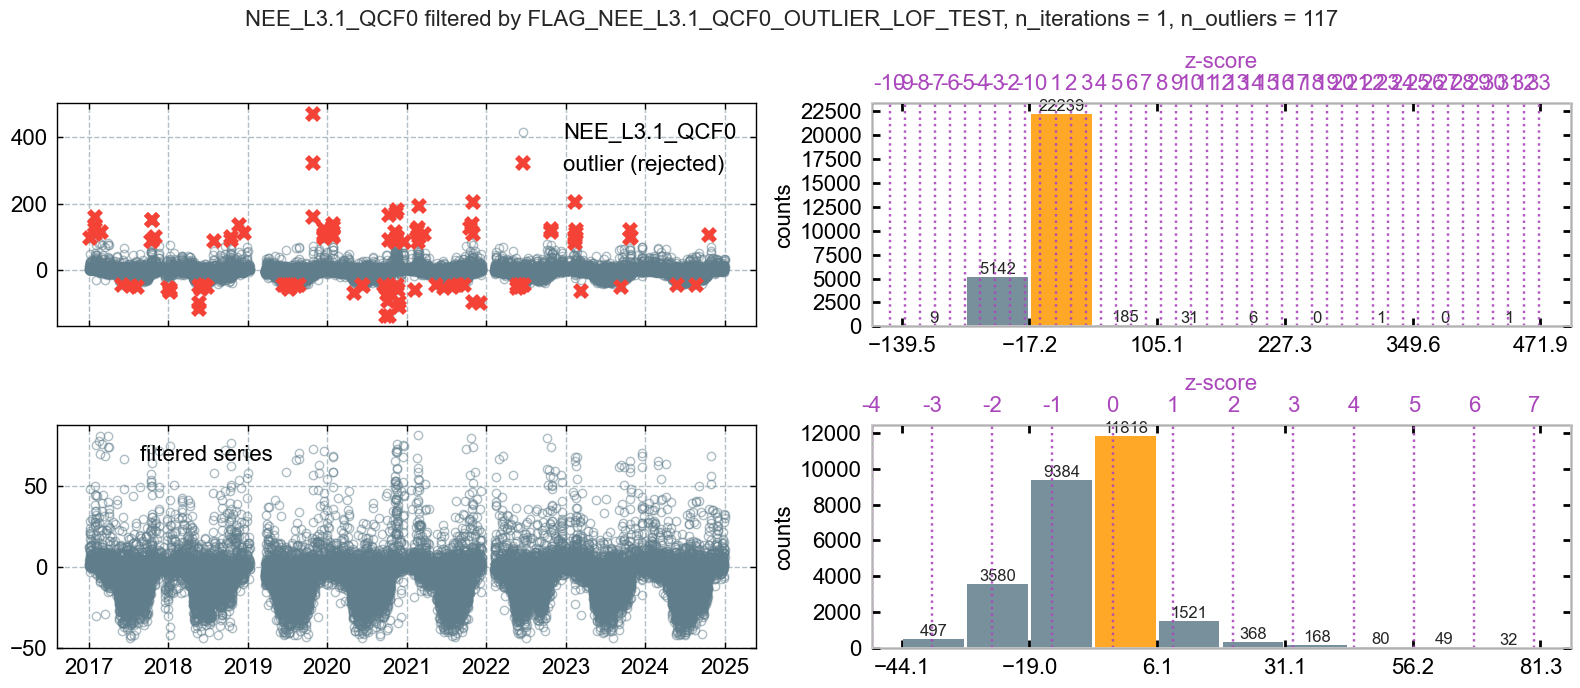

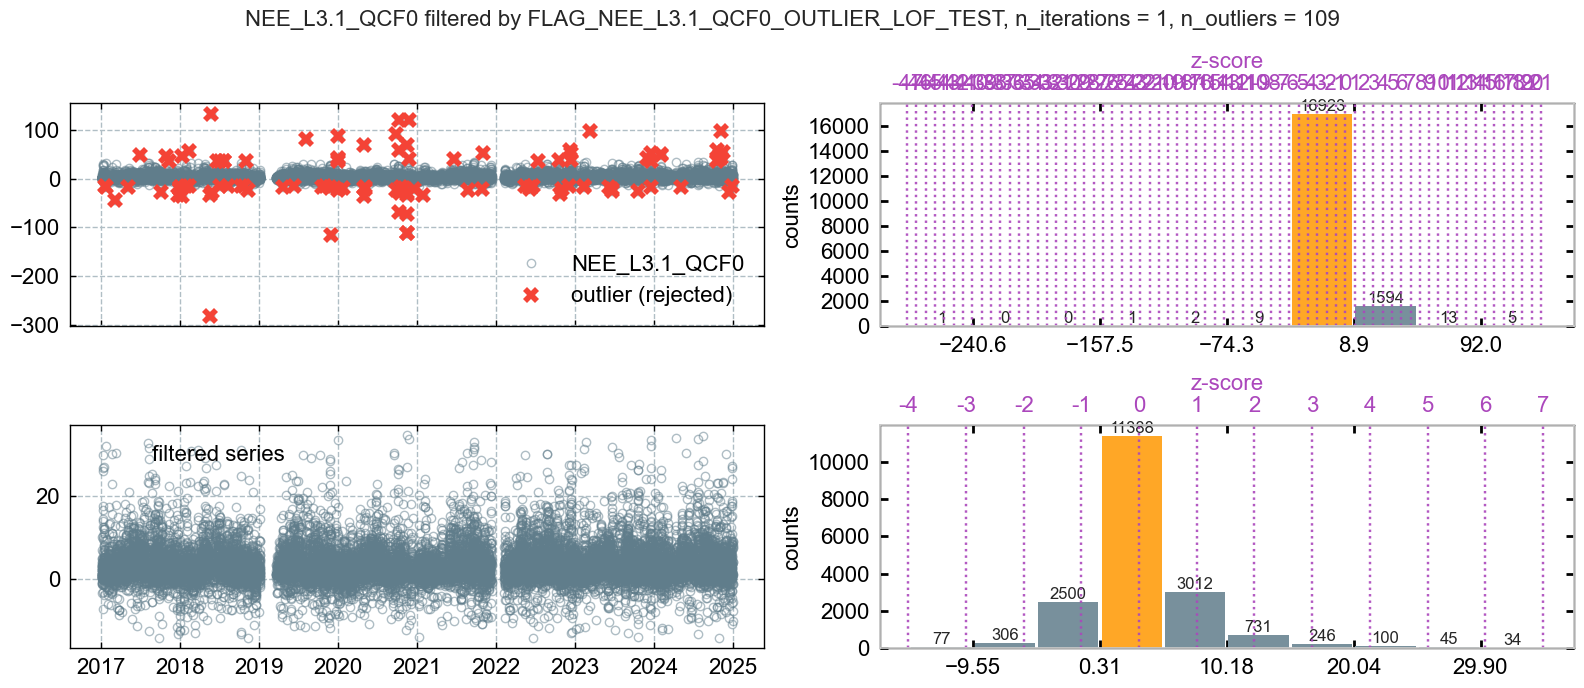

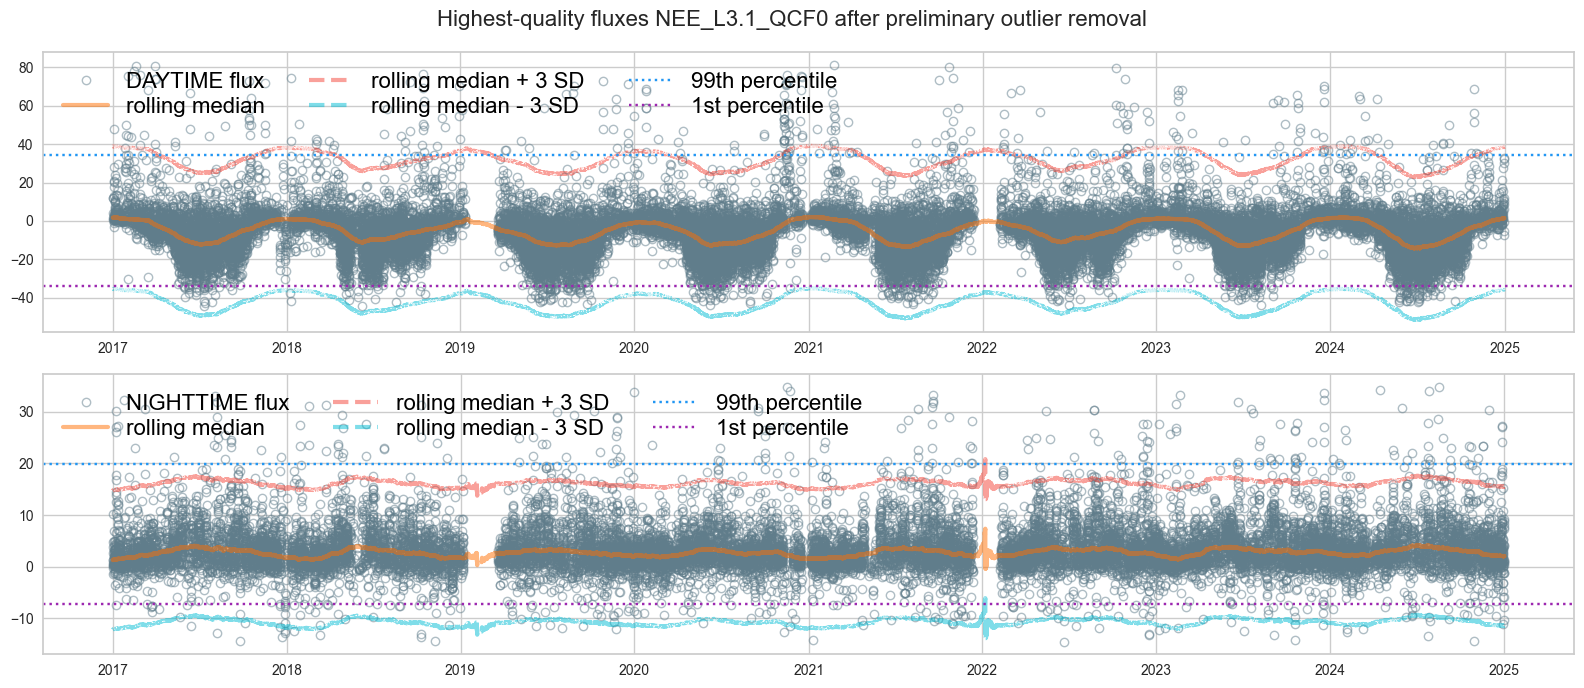

In [40]:
analyze_highest_quality_flux(flux=fpc.fpc_df[fpc.filteredseries_hq.name], nighttime_flag=fpc.fpc_df['NIGHTTIME'])

</br>

</br>

---

# Level-3.2: **OUTLIER DETECTION**

---

- Running an outlier test creates a *preview* plot of the results
- If the output looks as desired, run `fpc.level32_addflag()` cell below the preview to accept the results you see in the plot
- All subsequent tests will then be based on these results
- This means that each test is run on the data already filtered by the previous test
- Each test creates its own quality flag
- At the end of Level-3.2, an overall quality flag `QCF` is created that combines all of the individual flags into one single flag

</br>

## Plot time series

In [41]:
print(f"{fpc.filteredseries.name} \n(quality-controlled Level-3.1 version of {fpc.fluxcol})")

NEE_L3.1_QCF 
(quality-controlled Level-3.1 version of FC)


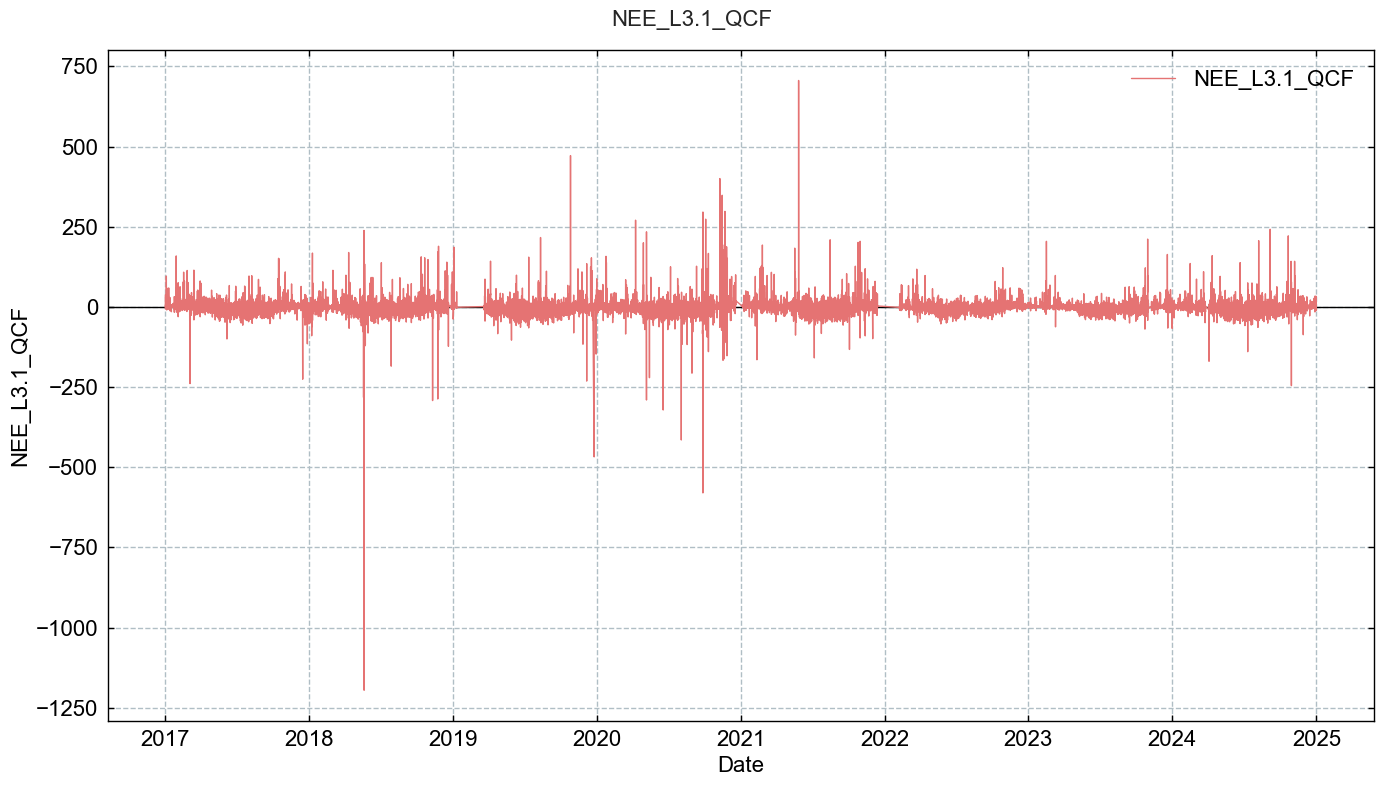

In [42]:
# TimeSeries(series=fpc.fpc_df[fpc.filteredseries.name]).plot_interactive()
TimeSeries(series=fpc.fpc_df[fpc.filteredseries.name]).plot()

</br>

## Initiate calculations

In [43]:
fpc.level32_stepwise_outlier_detection()

</br>

</br>

## Outlier flag: **Absolute limits**
- remove values outside a physically plausible range
- typical value for CO2 flux `FC`: +/-50 µmol m-2 s-1
- typical value for latent evaporation flux `LE`: +800 / -50 W m-2
- typical value for sensible heat flux `H`: +400 / -200 W m-2

In [44]:
# from diive.pkgs.outlierdetection.absolutelimits import AbsoluteLimits
# help(AbsoluteLimits)

[AbsoluteLimits]  running AbsoluteLimits ...


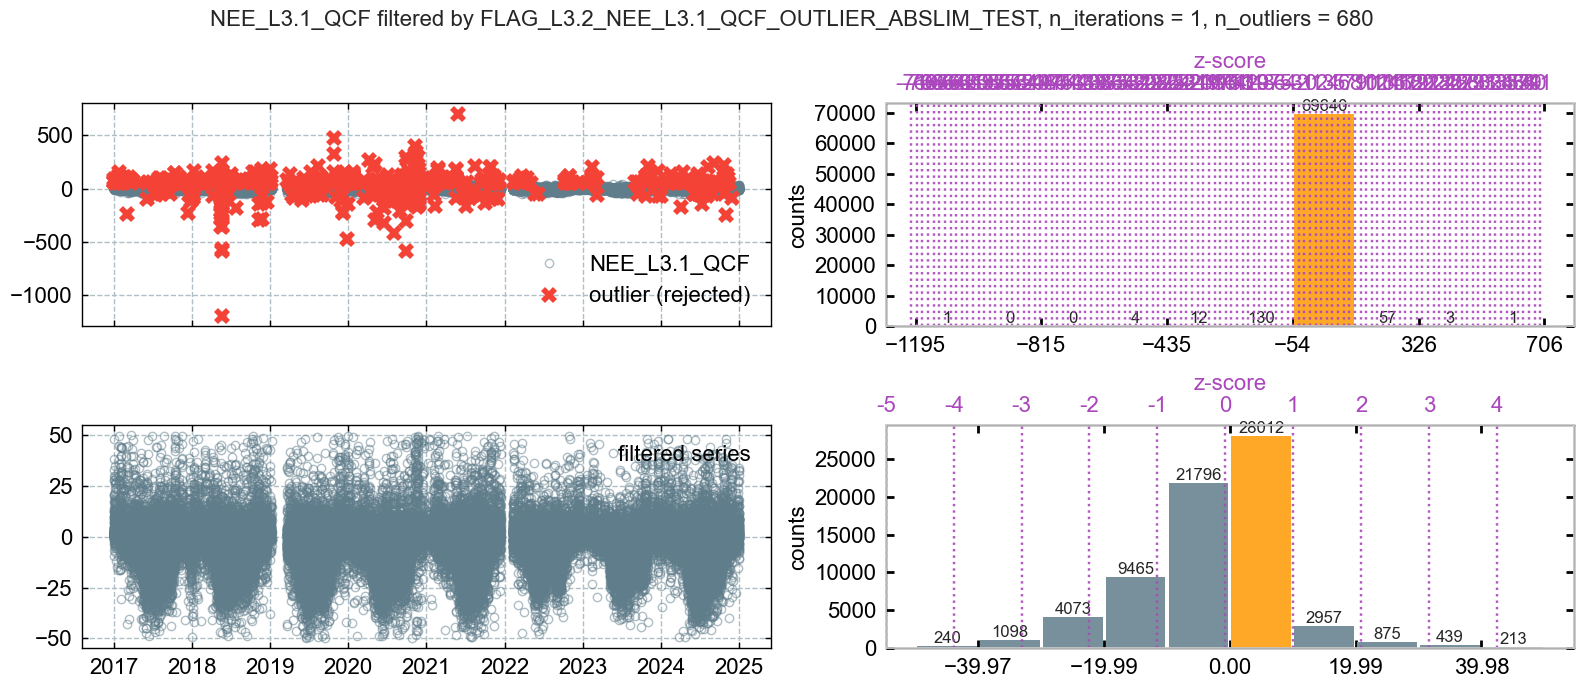

In [45]:
MIN = -50
MAX = 50
fpc.level32_flag_outliers_abslim_test(minval=MIN, maxval=MAX, showplot=True, verbose=True)

In [46]:
fpc.level32_addflag()

++Added flag column FLAG_L3.2_NEE_L3.1_QCF_OUTLIER_ABSLIM_TEST to flag data


</br>

</br>

## Outlier flag: **Manual flag**
- The interactive plot can be used to determine the exact start and end of time ranges or data points that need to be removed, e.g. due to known instrument failure

In [47]:
# from diive.pkgs.outlierdetection.manualremoval import ManualRemoval
# help(ManualRemoval)

In [48]:
# fpc.level32.showplot_cleaned(interactive=True)  # True or False
# fpc.level32.showplot_cleaned(interactive=False)  # True or False

[ManualRemoval]  running ManualRemoval ...


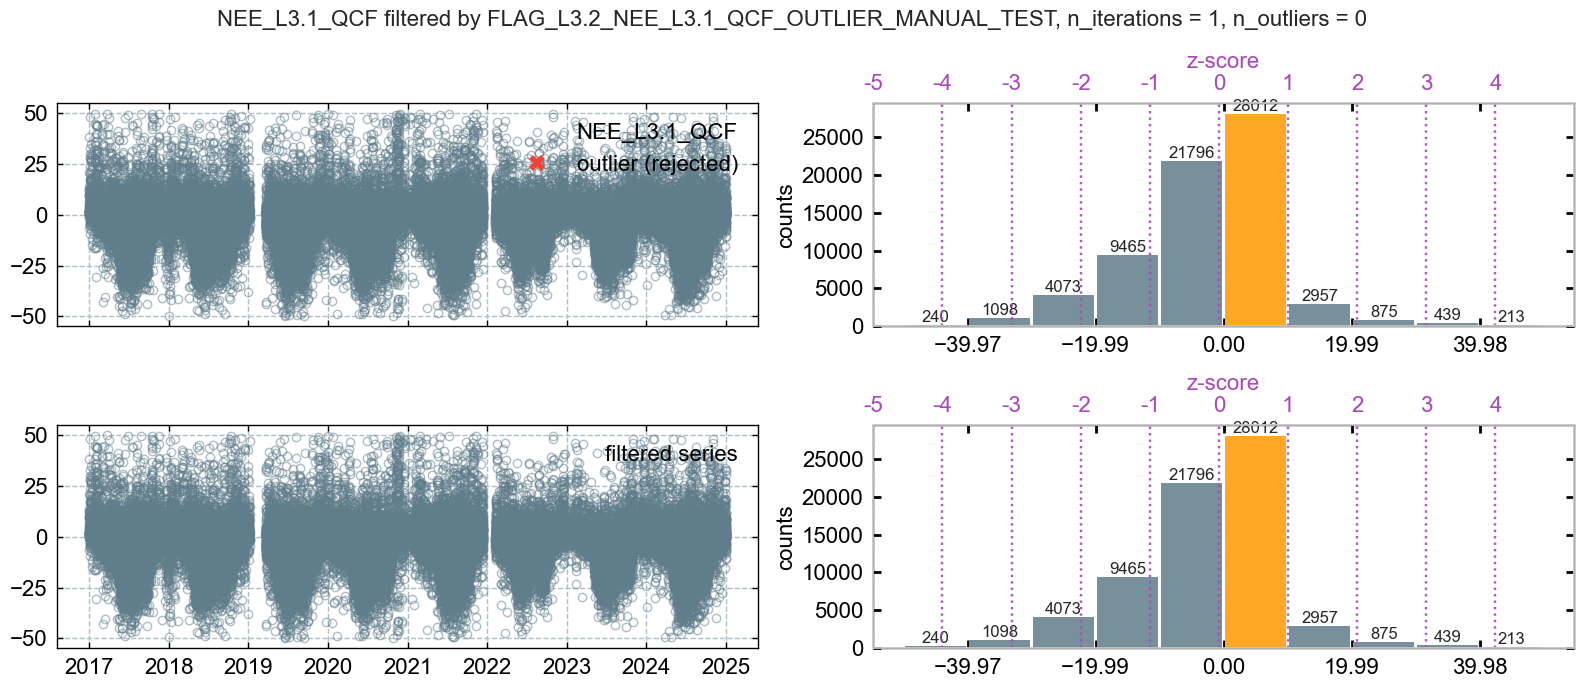

In [49]:
# Removes date range between two datetimes (inclusive)
REMOVE_DATES = [    
    ['2008-12-01', '2009-05-01']
]
fpc.level32_flag_manualremoval_test(
    remove_dates=REMOVE_DATES,
    showplot=True, verbose=True)

In [50]:
fpc.level32_addflag()

++Added flag column FLAG_L3.2_NEE_L3.1_QCF_OUTLIER_MANUAL_TEST to flag data


In [51]:
# fpc.level32.showplot_cleaned(interactive=True)  # True or False

</br>

</br>

## Outlier flag: **Hampel filter**, separate for daytime and nighttime
- Recommended filter
- Is slow compared to other filters:
    - tested with 1 year of 30MIN time resolution data and it needed approx. 43 seconds on a fast desktop computer

In [52]:
# from diive.pkgs.outlierdetection.hampel import Hampel
# help(Hampel)

[HampelDaytimeNighttime]  running HampelDaytimeNighttime ...
ITERATION#1: Total found outliers: 2845 (daytime+nighttime), 1730 (daytime), 1115 (nighttime)
ITERATION#2: Total found outliers: 317 (daytime+nighttime), 209 (daytime), 108 (nighttime)
ITERATION#3: Total found outliers: 29 (daytime+nighttime), 20 (daytime), 9 (nighttime)
ITERATION#4: Total found outliers: 3 (daytime+nighttime), 0 (daytime), 3 (nighttime)
ITERATION#5: Total found outliers: 0 (daytime+nighttime), 0 (daytime), 0 (nighttime)
CPU times: total: 2min 17s
Wall time: 2min 20s


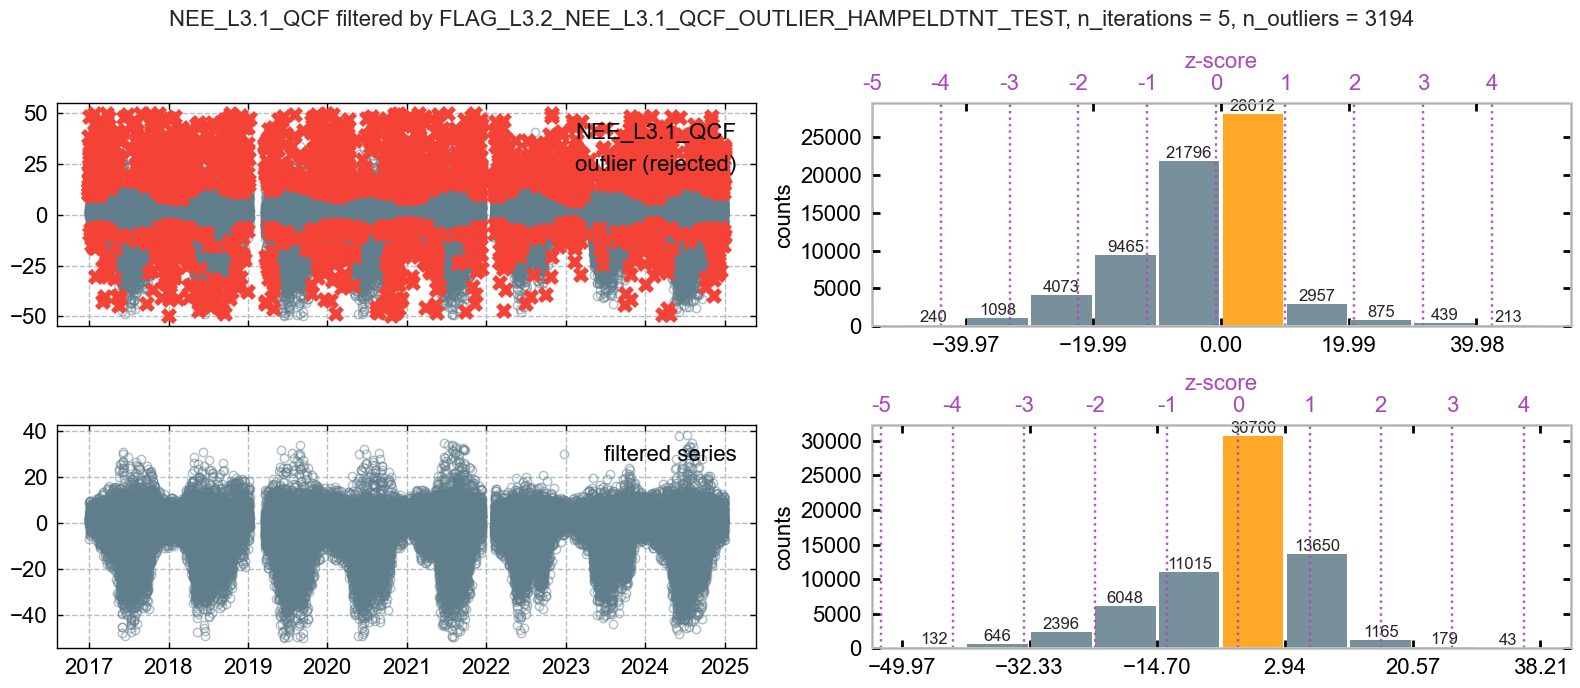

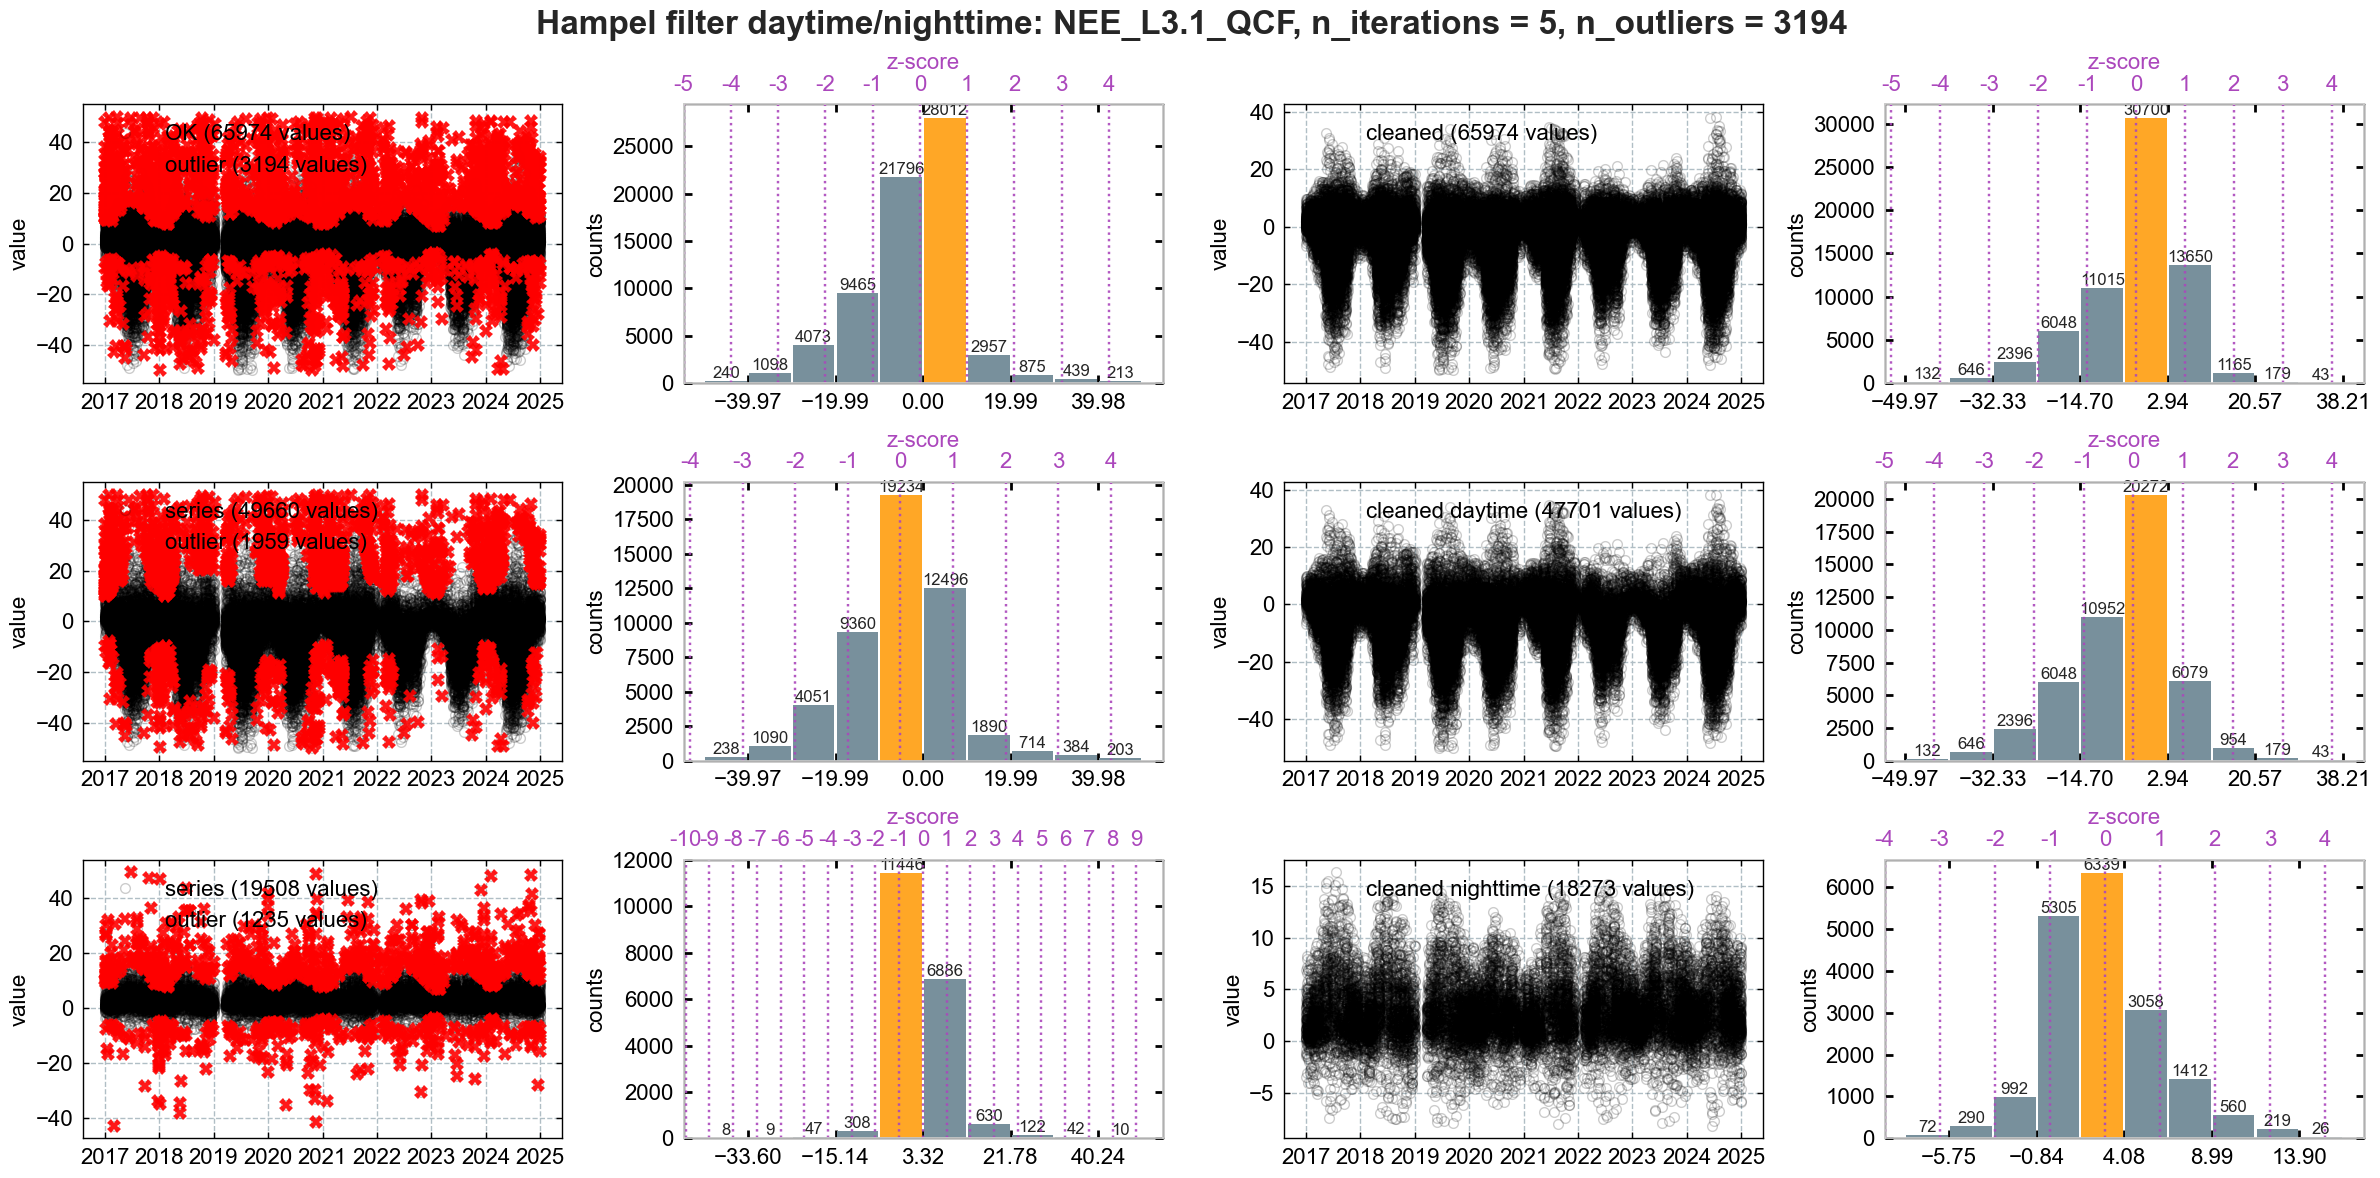

In [53]:
%%time
WINDOW_LENGTH = 48 * 13
N_SIGMA_DT = 3.5
N_SIGMA_NT = 3.5
fpc.level32_flag_outliers_hampel_dtnt_test(window_length=WINDOW_LENGTH, n_sigma_dt=N_SIGMA_DT, n_sigma_nt=N_SIGMA_NT,
                                           showplot=True, verbose=True, repeat=True)

In [54]:
fpc.level32_addflag()

++Added flag column FLAG_L3.2_NEE_L3.1_QCF_OUTLIER_HAMPELDTNT_TEST to flag data


</br>

</br>

## Outlier flag: **z-score across all data**

In [55]:
# from diive.pkgs.outlierdetection.zscore import zScore
# help(zScore)

In [56]:
# THRES_ZSCORE = 6
# fpc.level32_flag_outliers_zscore_test(thres_zscore=THRES_ZSCORE, showplot=True, verbose=True, repeat=True)

In [57]:
# fpc.level32_addflag()

</br>

</br>

## Outlier flag: **Hampel filter**
- Recommended filter
- Is slow compared to other filters:
    - tested with 1 year of 30MIN time resolution data and it needed approx. 33 seconds on a fast desktop computer
    - tested with 19 years of 30MIN time resolution data and it needed approx. 20 minutes on a fast desktop computer

In [58]:
# from diive.pkgs.outlierdetection.hampel import Hampel
# help(Hampel)

In [59]:
# WINDOW_LENGTH = 48 * 13
# N_SIGMA = 6
# %%time
# fpc.level32_flag_outliers_hampel_test(window_length=WINDOW_LENGTH, n_sigma=N_SIGMA, showplot=True, verbose=True, repeat=True)

In [60]:
# fpc.level32_addflag()

</br>

</br>

## Outlier flag: **z-score over all data**, separate for daytime and nighttime

In [61]:
# from diive.pkgs.outlierdetection.zscore import zScoreDaytimeNighttime
# help(zScoreDaytimeNighttime)

In [62]:
# THRES_ZSCORE = 5
# fpc.level32_flag_outliers_zscore_dtnt_test(thres_zscore=THRES_ZSCORE, showplot=True, verbose=True, repeat=True)

In [63]:
# fpc.level32_addflag()

</br>

</br>

## Outlier flag: **Rolling z-score over all data**

In [64]:
# from diive.pkgs.outlierdetection.zscore import zScoreRolling
# help(zScoreRolling)

In [65]:
# THRES_ZSCORE = 5.5
# WINSIZE = 48 * 13
# fpc.level32_flag_outliers_zscore_rolling_test(winsize=WINSIZE, thres_zscore=THRES_ZSCORE, showplot=True, verbose=True, repeat=True)

In [66]:
# fpc.level32_addflag()

</br>

</br>

## Outlier flag: **Local standard deviation**, with rolling median and *rolling* standard deviation

In [67]:
# from diive.pkgs.outlierdetection.localsd import LocalSD
# help(LocalSD)

In [68]:
# N_SD = 4.5
# WINSIZE = 48 * 9
# fpc.level32_flag_outliers_localsd_test(n_sd=N_SD, winsize=WINSIZE, constant_sd=False, showplot=True, verbose=True, repeat=True)

In [69]:
# fpc.level32_addflag()

</br>

</br>

## Outlier flag: **Local standard deviation**, with rolling median and *constant* standard deviation
- keep standard deviation constant by setting parameter `constant_sd=True`

In [70]:
# N_SD = 3.5
# WINSIZE = 48 * 13
# fpc.level32_flag_outliers_localsd_test(n_sd=N_SD, winsize=WINSIZE, constant_sd=True, showplot=True, verbose=True, repeat=True)

In [71]:
# fpc.level32_addflag()

</br>

</br>

## Outlier flag: **Increments z-score**

In [72]:
# from diive.pkgs.outlierdetection.incremental import zScoreIncrements
# help(zScoreIncrements)

In [73]:
# THRES_ZSCORE = 4
# fpc.level32_flag_outliers_increments_zcore_test(thres_zscore=THRES_ZSCORE, showplot=True, verbose=True, repeat=True)

In [74]:
# fpc.level32_addflag()

</br>

</br>

## Outlier flag: **Local outlier factor**, daytime/nighttime
- Test is run separately for daytime and nighttime data
- Description of local outlier factor: [here](https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.LocalOutlierFactor.html)

In [75]:
# from diive.pkgs.outlierdetection.lof import LocalOutlierFactorDaytimeNighttime
# help(LocalOutlierFactorDaytimeNighttime)

In [76]:
# N_NEIGHBORS = None
# CONTAMINATION = None
# fpc.level32_flag_outliers_lof_dtnt_test(n_neighbors=N_NEIGHBORS, contamination=CONTAMINATION, showplot=True, verbose=True, repeat=False, n_jobs=-1)

In [77]:
# fpc.level32_addflag()

</br>

</br>

## Outlier flag: **Local outlier factor**
- Test is run across all data
- Description of local outlier factor: [here](https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.LocalOutlierFactor.html)

In [78]:
# from diive.pkgs.outlierdetection.lof import LocalOutlierFactorAllData
# help(LocalOutlierFactorAllData)

In [79]:
# N_NEIGHBORS = 24
# CONTAMINATION = None
# fpc.level32_flag_outliers_lof_test(n_neighbors=N_NEIGHBORS, contamination=CONTAMINATION, showplot=True, verbose=True, repeat=False, n_jobs=-1)

In [80]:
# fpc.level32_addflag()

</br>

</br>

## Outlier flag: **Absolute limits**, separate for daytime and nighttime data

In [81]:
# from diive.pkgs.outlierdetection.absolutelimits import AbsoluteLimitsDaytimeNighttime
# help(AbsoluteLimitsDaytimeNighttime)

In [82]:
# MIN_DT = -50
# MAX_DT = 50
# MIN_NT = -25
# MAX_NT = 25
# fpc.level32_flag_outliers_abslim_dtnt_test(daytime_minmax=[MIN_DT, MAX_DT], nighttime_minmax=[MIN_NT, MAX_NT], showplot=True, verbose=True)

In [83]:
# fpc.level32_addflag()

</br>

</br>

## Outlier flag: **Trim nighttime flux data**

In [84]:
# from diive.pkgs.outlierdetection.trim import TrimLow
# help(TrimLow)

In [85]:
# fpc.level32_flag_outliers_trim_low_test(trim_nighttime=True, lower_limit=-5, showplot=True, verbose=True)

In [86]:
# fpc.level32_addflag()

</br>

</br>

## **Finalize Level-3.2**: Calculate overall quality flag (so far)

In [87]:
fpc.finalize_level32()

++Added new column FLAG_L3.2_NEE_L3.1_QCF_OUTLIER_ABSLIM_TEST.
++Added new column FLAG_L3.2_NEE_L3.1_QCF_OUTLIER_MANUAL_TEST.
++Added new column FLAG_L3.2_NEE_L3.1_QCF_OUTLIER_HAMPELDTNT_TEST.
++Added new column SUM_L3.2_NEE_L3.1_HARDFLAGS.
++Added new column SUM_L3.2_NEE_L3.1_SOFTFLAGS.
++Added new column SUM_L3.2_NEE_L3.1_FLAGS.
++Added new column FLAG_L3.2_NEE_L3.1_QCF.
++Added new column NEE_L3.1_L3.2_QCF.
++Added new column NEE_L3.1_L3.2_QCF0.


</br>

### Available `Level-3.2` variables
- This shows all available Level-3.2 variables for this flux

In [88]:
[x for x in fpc.fpc_df.columns if 'L3.2' in x]

['FLAG_L3.2_NEE_L3.1_QCF_OUTLIER_ABSLIM_TEST',
 'FLAG_L3.2_NEE_L3.1_QCF_OUTLIER_MANUAL_TEST',
 'FLAG_L3.2_NEE_L3.1_QCF_OUTLIER_HAMPELDTNT_TEST',
 'SUM_L3.2_NEE_L3.1_HARDFLAGS',
 'SUM_L3.2_NEE_L3.1_SOFTFLAGS',
 'SUM_L3.2_NEE_L3.1_FLAGS',
 'FLAG_L3.2_NEE_L3.1_QCF',
 'NEE_L3.1_L3.2_QCF',
 'NEE_L3.1_L3.2_QCF0']

</br>

### Plot filtered flux after Level-3.2
In the four panels, from left to right:
- flux after Level-3.1, before outlier removal
- flux after Level-3.2, after outlier removal
- sum of the individual test flags
- overall flag `QCF` (quality control flag), where `0`=best quality, `1`=medium quality, `2`=bad quality  

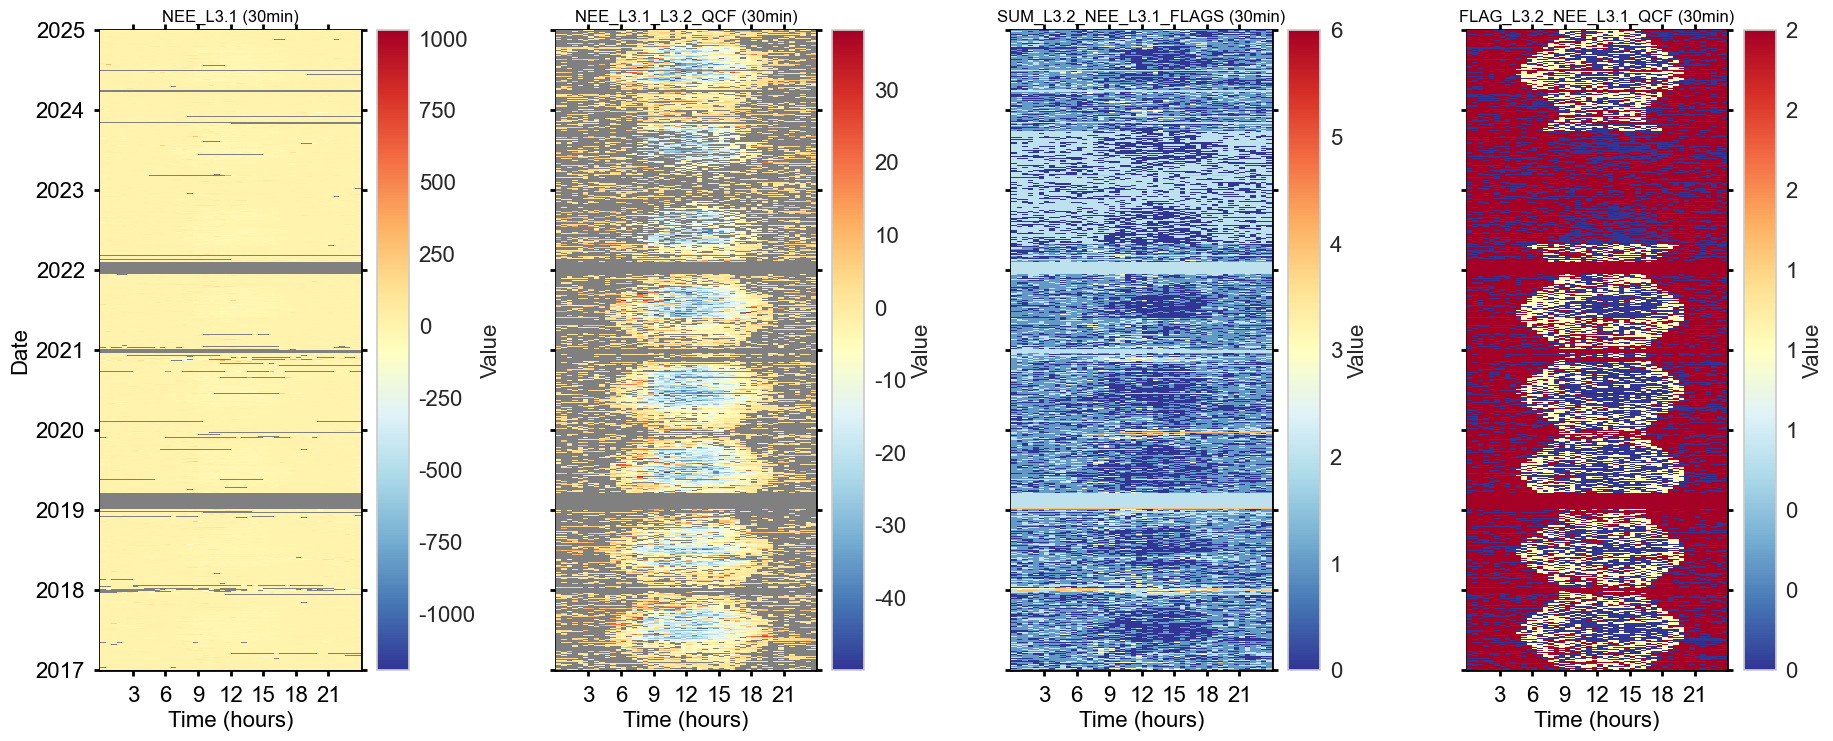

In [89]:
fpc.level32_qcf.showplot_qcf_heatmaps()

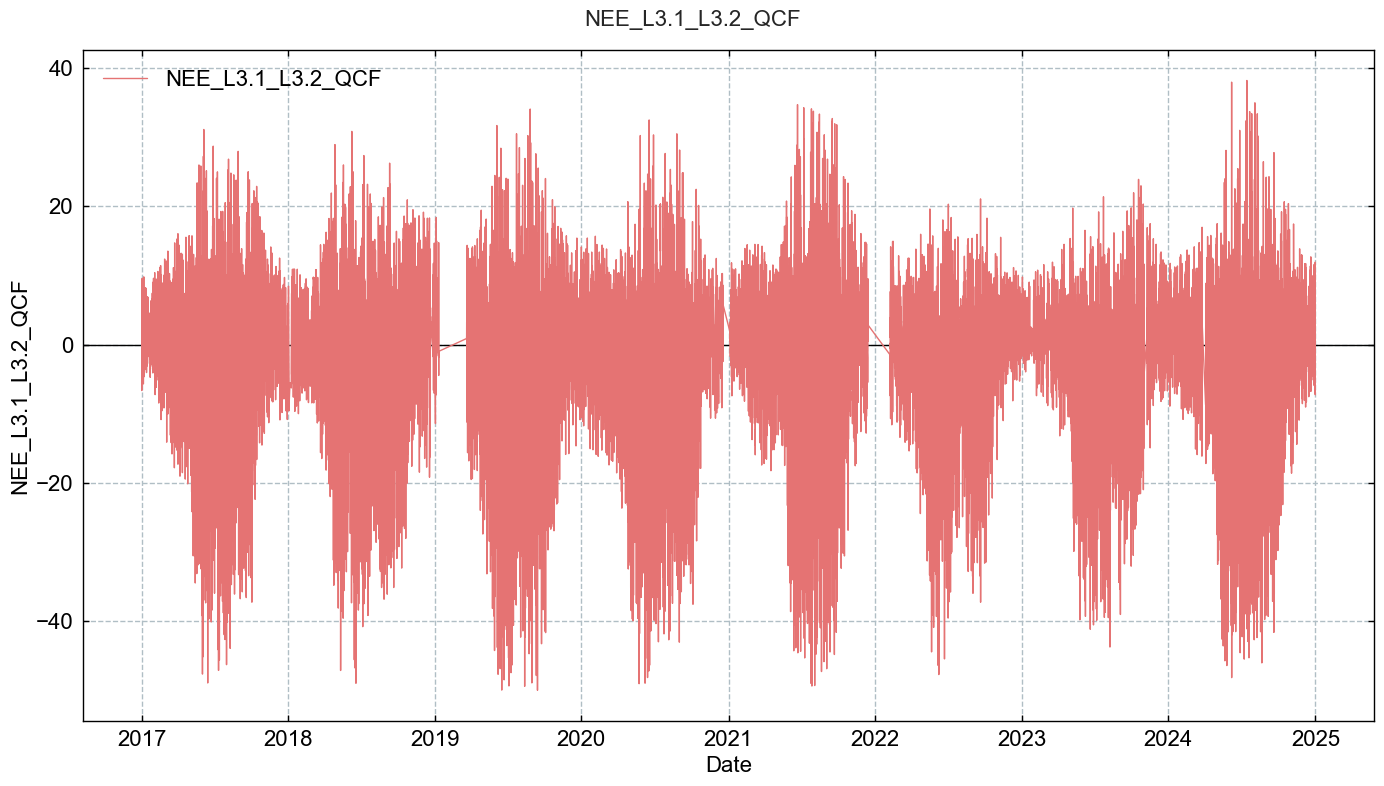

In [90]:
TimeSeries(series=fpc.filteredseries).plot()
# TimeSeries(series=fpc.filteredseries).plot_interactive()

In [91]:
# fpc.level32_qcf.showplot_qcf_timeseries()

</br>

### Reports

In [92]:
fpc.level32_qcf.report_qcf_evolution()



QCF FLAG EVOLUTION
This output shows the evolution of the QCF overall quality flag
when test flags are applied sequentially to the variable NEE_L3.1.

Number of NEE_L3.1 records before QC: 128967
+++ FLAG_L2_FC_MISSING_TEST rejected 0 values (+0.00%)      TOTALS: flag 0: 128967 (100.00%) / flag 1: 0 (0.00%) / flag 2: 0 (0.00%)
+++ FLAG_L2_FC_SSITC_TEST rejected 58965 values (+45.72%)      TOTALS: flag 0: 46234 (35.85%) / flag 1: 23768 (18.43%) / flag 2: 58965 (45.72%)
+++ FLAG_L2_FC_SCF_TEST rejected 0 values (+0.00%)      TOTALS: flag 0: 46234 (35.85%) / flag 1: 23768 (18.43%) / flag 2: 58965 (45.72%)
+++ FLAG_L2_FC_SIGNAL_STRENGTH_TEST rejected 146 values (+0.11%)      TOTALS: flag 0: 46167 (35.80%) / flag 1: 23689 (18.37%) / flag 2: 59111 (45.83%)
+++ FLAG_L2_FC_CO2_VM97_SPIKE_HF_TEST rejected 8 values (+0.01%)      TOTALS: flag 0: 46162 (35.79%) / flag 1: 23686 (18.37%) / flag 2: 59119 (45.84%)
+++ FLAG_L2_FC_CO2_VM97_DROPOUT_TEST rejected 0 values (+0.00%)      TOTALS: flag 0: 4

In [93]:
fpc.level32_qcf.report_qcf_series()



SUMMARY: FLAG_L3.2_NEE_L3.1_QCF, QCF FLAG FOR NEE_L3.1
Between 2017-01-01 00:15 and 2024-12-31 23:45 ...
    Total flux records BEFORE quality checks: 128967 (91.95% of potential)
    Available flux records AFTER quality checks: 65974 (51.16% of total)
    Rejected flux records: 62993 (48.84% of total)
    Potential flux records: 140256
    Potential flux records missed: 11289 (8.05% of potential)



In [94]:
fpc.level32_qcf.report_qcf_flags()


REPORT: FLAGS INCL. MISSING VALUES
Stats with missing values in the dataset
FLAG_L2_FC_MISSING_TEST:
    OVERALL flag 0.0: 128967 values (91.95%)  
    OVERALL flag 2.0: 11289 values (8.05%)  
    OVERALL flag missing: 0 values (0.00%)  

    DAYTIME flag 0.0: 64515 values (93.61%)  
    DAYTIME flag 2.0: 4405 values (6.39%)  
    DAYTIME flag missing: 0 values (0.00%)  

    NIGHTTIME flag 0.0: 64452 values (90.35%)  
    NIGHTTIME flag 2.0: 6884 values (9.65%)  
    NIGHTTIME flag missing: 0 values (0.00%)  

FLAG_L2_FC_SSITC_TEST:
    OVERALL flag 0.0: 46234 values (32.96%)  
    OVERALL flag 1.0: 53403 values (38.08%)  
    OVERALL flag 2.0: 29330 values (20.91%)  
    OVERALL flag missing: 11289 values (8.05%)  

    DAYTIME flag 0.0: 27642 values (40.11%)  
    DAYTIME flag 1.0: 23768 values (34.49%)  
    DAYTIME flag 2.0: 13105 values (19.01%)  
    DAYTIME flag missing: 4405 values (6.39%)  

    NIGHTTIME flag 0.0: 18592 values (26.06%)  
    NIGHTTIME flag 1.0: 29635 values

</br>

## Save Level-3.2 results to file
- If needed, save results so far (input data and all created variables, e.g. flags and filtered fluxes) to a file
- This can be useful if e.g. USTAR filtering is not needed and gap-filling is done elsewhere (ReddyProc...)

In [95]:
# results_df = fpc.get_data()
# filename = "51.1_FluxProcessingChain_after-L3.3_NEE"
# results_df.to_csv(f"{filename}.csv", index=True)
# save_parquet(data=results_df, filename=filename)

</br>

</br>

---

# Level-3.3: **USTAR FILTERING**

---

- Daytime and nighttime data are filtered based on USTAR thresholds
- Example USTAR thresholds from the analysis done by FLUXNET (2005-2023) for the intensively managed grassland [CH-CHA, Chamau](https://www.swissfluxnet.ethz.ch/index.php/sites/site-info-ch-cha/):
    - CUT_16: `0.0529445`
    - CUT_50: `0.0698982`
    - CUT_84: `0.0928408`

<div class="alert alert-block alert-danger">
    No USTAR filtering for: <b>H, LE, ET and FH2O.</b> 
</div>

> The USTAR filtering is not applied to H and LE, because it has not been proved that when there are CO2 advective fluxes, these also impact energy fluxes, specifically due to the fact that when advection is in general large (nighttime), energy fluxes are small.

source: [Pastorello et al. (2020). The FLUXNET2015 dataset and the ONEFlux processing pipeline for eddy covariance data](https://doi.org/10.1038/s41597-020-0534-3)



In [96]:
USTAR_SCENARIOS = ['CUT_50']
USTAR_THRESHOLDS = [0.3]
# USTAR_SCENARIOS = ['CUT_16', 'CUT_50', 'CUT_84']
# USTAR_THRESHOLDS = [0.0529445, 0.0698982, 0.0928408]
fpc.level33_constant_ustar(thresholds=USTAR_THRESHOLDS,
                           threshold_labels=USTAR_SCENARIOS,
                           showplot=False)

[FlagSingleConstantUstarThreshold]  running FlagSingleConstantUstarThreshold ...
Total found outliers for USTAR threshold _L3.3_CUT_50 0.3: 42827 values


</br>

## **Finalize Level-3.3**: Caculate overall final quality flag

In [97]:
# Finalize: stores results for each USTAR scenario in a dict
fpc.finalize_level33()

Calculating overall quality flag QCF for USTAR scenario CUT_50...
++Added new column FLAG_L3.3_CUT_50_NEE_L3.1_USTAR_TEST.
++Added new column SUM_L3.3_CUT_50_NEE_L3.1_HARDFLAGS.
++Added new column SUM_L3.3_CUT_50_NEE_L3.1_SOFTFLAGS.
++Added new column SUM_L3.3_CUT_50_NEE_L3.1_FLAGS.
++Added new column FLAG_L3.3_CUT_50_NEE_L3.1_QCF.
++Added new column NEE_L3.1_L3.3_CUT_50_QCF.
++Added new column NEE_L3.1_L3.3_CUT_50_QCF0.


</br>

### Available `Level-3.3` variables
- This shows all available Level-3.3 variables for this flux

In [98]:
[x for x in fpc.fpc_df.columns if 'L3.3' in x]

['FLAG_L3.3_CUT_50_NEE_L3.1_USTAR_TEST',
 'SUM_L3.3_CUT_50_NEE_L3.1_HARDFLAGS',
 'SUM_L3.3_CUT_50_NEE_L3.1_SOFTFLAGS',
 'SUM_L3.3_CUT_50_NEE_L3.1_FLAGS',
 'FLAG_L3.3_CUT_50_NEE_L3.1_QCF',
 'NEE_L3.1_L3.3_CUT_50_QCF',
 'NEE_L3.1_L3.3_CUT_50_QCF0']

</br>

### Plot filtered flux after Level-3.3
In the four panels, from left to right:
- flux after Level-3.1, before outlier removal and USTAR filtering
- flux after Level-3.3, after outlier removal and USTAR filtering
- sum of the individual test flags
- overall flag `QCF` (quality control flag), where `0`=best quality, `1`=medium quality, `2`=bad quality  

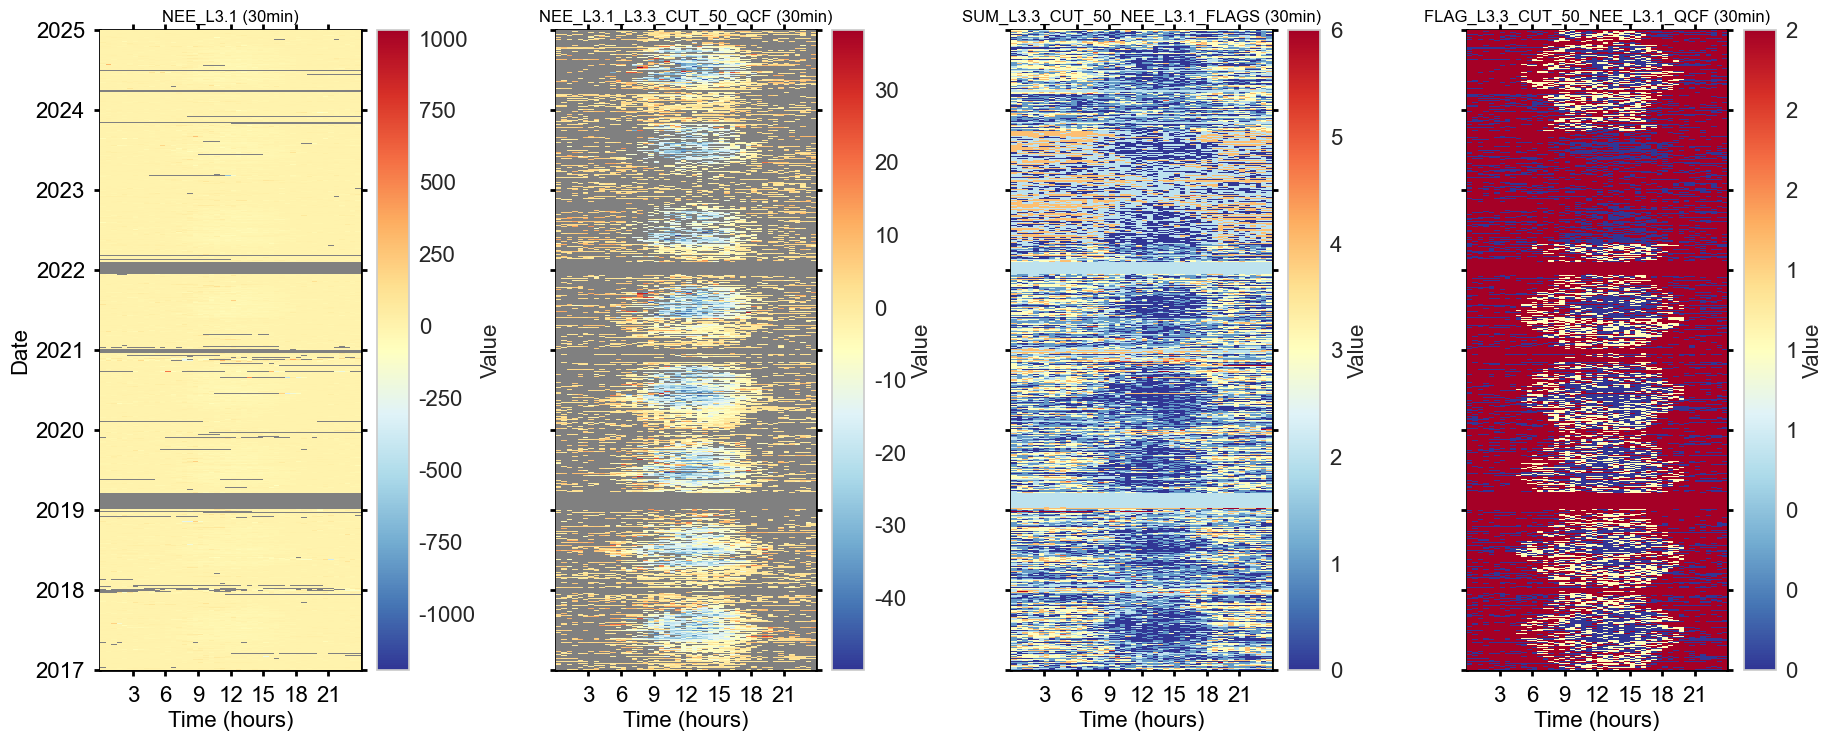

In [99]:
for key, value in fpc.level33_qcf.items():
    # TimeSeries(series=fpc.fpc_df[fluxhq]).plot_interactive()
    # TimeSeries(series=fpc.fpc_df[FLUXVAR33QCF[key].name]).plot()
    fpc.level33_qcf[key].showplot_qcf_heatmaps()

</br>

### Reports

In [100]:
for key, value in fpc.level33_qcf.items():
    fpc.level33_qcf[key].report_qcf_evolution()



QCF FLAG EVOLUTION
This output shows the evolution of the QCF overall quality flag
when test flags are applied sequentially to the variable NEE_L3.1.

Number of NEE_L3.1 records before QC: 128967
+++ FLAG_L2_FC_MISSING_TEST rejected 0 values (+0.00%)      TOTALS: flag 0: 128967 (100.00%) / flag 1: 0 (0.00%) / flag 2: 0 (0.00%)
+++ FLAG_L2_FC_SSITC_TEST rejected 58965 values (+45.72%)      TOTALS: flag 0: 46234 (35.85%) / flag 1: 23768 (18.43%) / flag 2: 58965 (45.72%)
+++ FLAG_L2_FC_SCF_TEST rejected 0 values (+0.00%)      TOTALS: flag 0: 46234 (35.85%) / flag 1: 23768 (18.43%) / flag 2: 58965 (45.72%)
+++ FLAG_L2_FC_SIGNAL_STRENGTH_TEST rejected 146 values (+0.11%)      TOTALS: flag 0: 46167 (35.80%) / flag 1: 23689 (18.37%) / flag 2: 59111 (45.83%)
+++ FLAG_L2_FC_CO2_VM97_SPIKE_HF_TEST rejected 8 values (+0.01%)      TOTALS: flag 0: 46162 (35.79%) / flag 1: 23686 (18.37%) / flag 2: 59119 (45.84%)
+++ FLAG_L2_FC_CO2_VM97_DROPOUT_TEST rejected 0 values (+0.00%)      TOTALS: flag 0: 4

In [101]:
for key, value in fpc.level33_qcf.items():
    fpc.level33_qcf[key].report_qcf_series()



SUMMARY: FLAG_L3.3_CUT_50_NEE_L3.1_QCF, QCF FLAG FOR NEE_L3.1
Between 2017-01-01 00:15 and 2024-12-31 23:45 ...
    Total flux records BEFORE quality checks: 128967 (91.95% of potential)
    Available flux records AFTER quality checks: 51861 (40.21% of total)
    Rejected flux records: 77106 (59.79% of total)
    Potential flux records: 140256
    Potential flux records missed: 11289 (8.05% of potential)



In [102]:
for key, value in fpc.level33_qcf.items():
    fpc.level33_qcf[key].report_qcf_flags()


REPORT: FLAGS INCL. MISSING VALUES
Stats with missing values in the dataset
FLAG_L2_FC_MISSING_TEST:
    OVERALL flag 0.0: 128967 values (91.95%)  
    OVERALL flag 2.0: 11289 values (8.05%)  
    OVERALL flag missing: 0 values (0.00%)  

    DAYTIME flag 0.0: 64515 values (93.61%)  
    DAYTIME flag 2.0: 4405 values (6.39%)  
    DAYTIME flag missing: 0 values (0.00%)  

    NIGHTTIME flag 0.0: 64452 values (90.35%)  
    NIGHTTIME flag 2.0: 6884 values (9.65%)  
    NIGHTTIME flag missing: 0 values (0.00%)  

FLAG_L2_FC_SSITC_TEST:
    OVERALL flag 0.0: 46234 values (32.96%)  
    OVERALL flag 1.0: 53403 values (38.08%)  
    OVERALL flag 2.0: 29330 values (20.91%)  
    OVERALL flag missing: 11289 values (8.05%)  

    DAYTIME flag 0.0: 27642 values (40.11%)  
    DAYTIME flag 1.0: 23768 values (34.49%)  
    DAYTIME flag 2.0: 13105 values (19.01%)  
    DAYTIME flag missing: 4405 values (6.39%)  

    NIGHTTIME flag 0.0: 18592 values (26.06%)  
    NIGHTTIME flag 1.0: 29635 values

</br>

</br>

## Overview: data after `Level-3.3`

## Flux variable names

In [103]:
fluxes_qcf = [c for c in fpc.fpc_df.columns if str(c).endswith("_QCF") and not str(c).startswith("FLAG_") and "L3.3" in c]
fluxes_qcf0 = [c for c in fpc.fpc_df.columns if
               str(c).endswith("_QCF0") and not str(c).startswith("FLAG_") and "L3.3" in c]
print(f"Quality-controlled fluxes: {fluxes_qcf}")
print(f"Quality-controlled fluxes, HIGHEST QUALITY: {fluxes_qcf0}")
if (DAYTIME_ACCEPT_QCF_BELOW == 1) & (NIGHTTIMETIME_ACCEPT_QCF_BELOW == 1):
    print(f"{'*' * 100}\nNote that since only QCF below 1 is accepted for daytime and nighttime data, "
          f"the _QCF and _QCF0 variables are identical.")

Quality-controlled fluxes: ['NEE_L3.1_L3.3_CUT_50_QCF']
Quality-controlled fluxes, HIGHEST QUALITY: ['NEE_L3.1_L3.3_CUT_50_QCF0']


</br>

In [104]:
FLUXVAR2QCF = fpc.filteredseries_level2_qcf.name
FLUXVAR31QCF = fpc.filteredseries_level31_qcf.name
FLUXVAR32QCF = fpc.filteredseries_level32_qcf.name
FLUXVAR32QCF_HQ = f"{FLUXVAR32QCF}0"
FLUXVAR33QCF = fpc.filteredseries_level33_qcf

print("--------------------------")
print("OVERVIEW OF FLUX VARIABLES")
print("--------------------------")
print(
    f""
    f"{FLUXVAR} ... original input flux\n"
    f"{FLUXVAR2QCF} ... flux quality-controlled with Level-2 flags\n    -->  not used in any further processing steps\n"
    f"{FLUXVAR31QCF} ... flux quality-controlled with Level-2 flags, including Level-3.1 storage correction\n   -->  not used in any further processing steps\n"
    f"{FLUXVAR32QCF} ... flux quality-controlled with Level-2 and Level-3.2 flags, including Level-3.1 storage correction)\n    -->  not used in any further processing steps\n"
    f"{FLUXVAR32QCF_HQ} ... highest-quality flux (QCF=0), quality-controlled with Level-2 and Level-3.2 flags, including Level-3.1 storage correction)\n    -->  not used in any further processing steps\n"
)
print("Variables for further steps:")
for key, value in FLUXVAR33QCF.items():
    print(
        f"{FLUXVAR33QCF[key].name} ... flux quality-controlled with Level-2 and Level-3.2 flags, and after Level-3.3 USTAR filtering ({key}), including Level-3.1 storage correction\n-->   to be used in gap-filling and all further steps")

if (DAYTIME_ACCEPT_QCF_BELOW == 1) & (NIGHTTIMETIME_ACCEPT_QCF_BELOW == 1):
    print(f"{'*' * 100}\nNote that since only QCF below 1 is accepted for daytime and nighttime data, "
          f"the _QCF and _QCF0 variables are identical.")

--------------------------
OVERVIEW OF FLUX VARIABLES
--------------------------
FC ... original input flux
FC_L2_QCF ... flux quality-controlled with Level-2 flags
    -->  not used in any further processing steps
NEE_L3.1_QCF ... flux quality-controlled with Level-2 flags, including Level-3.1 storage correction
   -->  not used in any further processing steps
NEE_L3.1_L3.2_QCF ... flux quality-controlled with Level-2 and Level-3.2 flags, including Level-3.1 storage correction)
    -->  not used in any further processing steps
NEE_L3.1_L3.2_QCF0 ... highest-quality flux (QCF=0), quality-controlled with Level-2 and Level-3.2 flags, including Level-3.1 storage correction)
    -->  not used in any further processing steps

Variables for further steps:
NEE_L3.1_L3.3_CUT_50_QCF ... flux quality-controlled with Level-2 and Level-3.2 flags, and after Level-3.3 USTAR filtering (CUT_50), including Level-3.1 storage correction
-->   to be used in gap-filling and all further steps


</br>

</br>

## Plot quality-controlled flux after `Level-3.3`
- Plot flux after storage-correction, flux quality control, outlier removal and USTAR filtering

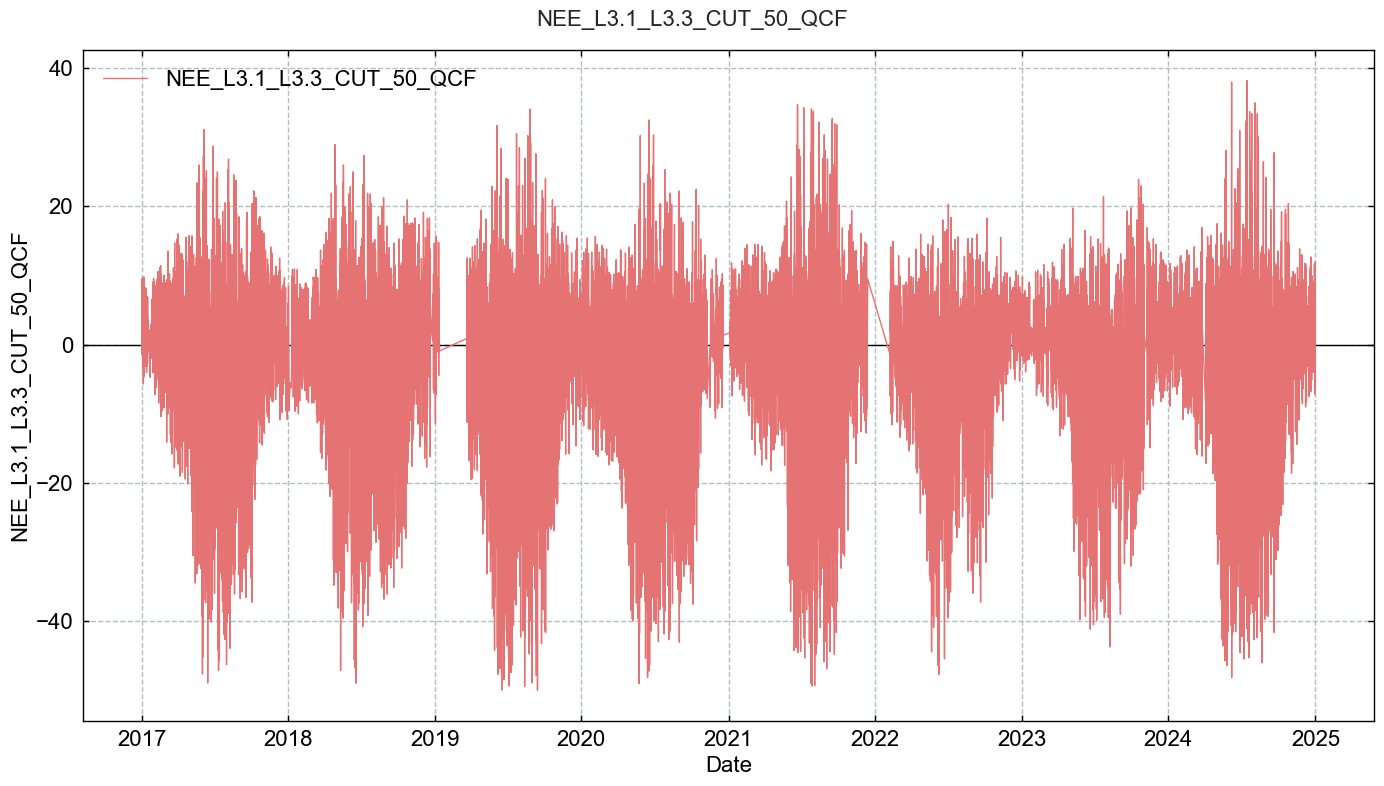

In [105]:
for key, value in FLUXVAR33QCF.items():
    # TimeSeries(series=fpc.fpc_df[fluxhq]).plot_interactive()
    TimeSeries(series=fpc.fpc_df[FLUXVAR33QCF[key].name]).plot()

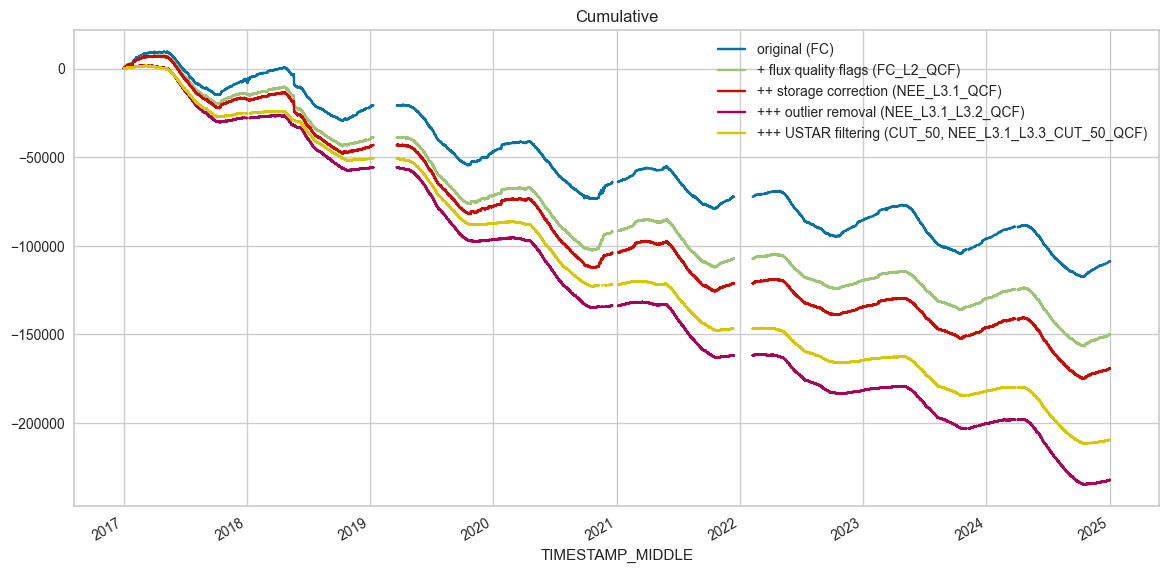

In [106]:
# Creating a dictionary by passing Series objects as values

frame = {
    f'original ({FLUXVAR})': fpc.fpc_df[FLUXVAR],
    f'+ flux quality flags ({FLUXVAR2QCF})': fpc.fpc_df[FLUXVAR2QCF],
    f'++ storage correction ({FLUXVAR31QCF})': fpc.fpc_df[FLUXVAR31QCF],
    f'+++ outlier removal ({FLUXVAR32QCF})': fpc.fpc_df[FLUXVAR32QCF]
}
for key, value in FLUXVAR33QCF.items():
    frame[f'+++ USTAR filtering ({key}, {FLUXVAR33QCF[key].name})'] = FLUXVAR33QCF[key]

overview = pd.DataFrame(frame)
overview.cumsum().plot(title=f"Cumulative", figsize=(14, 7), x_compat=True, alpha=1);

</br>

</br>

## Available `Level-3.3` fluxes

In [107]:
_fluxcols = [x for x in fpc.fpc_df.columns if
             'L3.1' and 'L3.3' in x and str(x).endswith('_QCF') and not str(x).startswith('FLAG_')]
_fluxcols

['NEE_L3.1_L3.3_CUT_50_QCF']

In [108]:
_subset = fpc.fpc_df[_fluxcols].copy()
_subset.head()

NEE_L3.1_L3.3_CUT_50_QCF
TIMESTAMP_MIDDLE                             
2017-01-01 00:15:00                       NaN
2017-01-01 00:45:00                       NaN
2017-01-01 01:15:00                       NaN
2017-01-01 01:45:00                       NaN
2017-01-01 02:15:00                       NaN

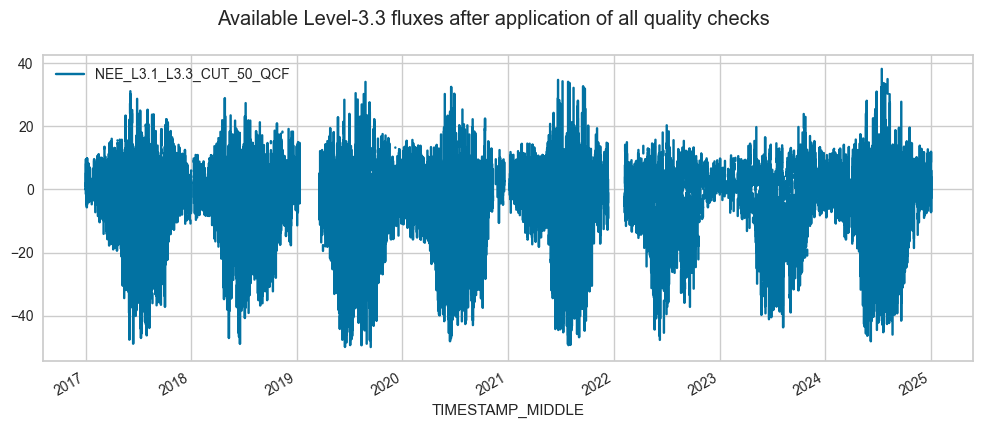

In [109]:
_subset.plot(subplots=True, x_compat=True,
             title="Available Level-3.3 fluxes after application of all quality checks", figsize=(12, 4.5));

In [110]:
# # Draw boxplots
# for _f in _fluxcols:
#     boxplots_df = fpc.fpc_df[[_f, "DAYTIME"]].copy()
#     boxplots_df["MONTH"] = boxplots_df.index.month
#     sns.set_theme(style="ticks", palette="pastel")
#     plt.figure(figsize=(12, 3))
#     sns.boxplot(x="MONTH", y=_f, palette=["r", "b"], hue="DAYTIME", data=boxplots_df).set_title(f"Boxplot of {_f}")
#     sns.despine(offset=10, trim=True)
#     plt.axhline(0, color="black");

In [111]:
# # Draw a nested violinplot and split the violins for easier comparison
# for _f in _fluxcols:
#     plt.figure(figsize=(20, 2))
#     sns.violinplot(data=boxplots_df, x="MONTH", y=fpc.fpc_df[_f], hue="DAYTIME", split=True, palette=["r", "b"], gap=.1,
#                    inner="quart")
#     plt.axhline(0, color="black")

</br>

## Save Level-3.3 results to file
- If needed, save results so far (input data and all created variables, e.g. flags and filtered fluxes) to a file
- This can be useful if e.g. gap-filling should be done elsewhere (ReddyProc...)

In [112]:
# # results_df = fpc.get_data()
# out_df = fpc.fpc_df.copy()
# filename = "32.2_FluxProcessingChain_L3.3_NEE-results"
# out_df.to_csv(f"{filename}.csv", index=True)
# save_parquet(data=out_df, filename=filename)

</br>

</br>

## Export for MDS gap-filling in REddyProc

In [113]:
# from diive.core.times.times import insert_timestamp
# export = results_df.copy()

In [114]:
# exportcols = ['NEE_L3.1_L3.3_CUT_16_QCF', 'NEE_L3.1_L3.3_CUT_50_QCF', 'NEE_L3.1_L3.3_CUT_84_QCF',
#               'SW_IN_T1_2_1', 'TA_T1_2_1', 'VPD_T1_2_1']
# export = export[exportcols].copy()
# locs = (export.index.year >= 2005) & (export.index.year <= 2023)
# export = export[locs].copy()
# export = insert_timestamp(data=export, convention="end", set_as_index=True)
# export

In [115]:
# filename = "32.3_FluxProcessingChain_L3.3_NEE-subset-forREddyProc"
# export.to_csv(f"{filename}.csv", index=True)
# save_parquet(data=export, filename=filename)

</br>

---

# Level-4.1: **GAP-FILLING**

---

- Introduced in `diive` v0.85.0, gap-filling can now be done using both random forest and MDS
- For gap-filling using MDS, make sure that variables are in the required units: short-wave incoming radiation in `W m-2`, air temperature in `°C`, VPD in `hPa`

Parameters:
- `mds_settings` are parameters for the MDS gap-filling method, [see docstring here for more details](https://github.com/holukas/diive/blob/main/diive/pkgs/gapfilling/mds.py)
- `rf_settings` are parameters for scikit's `RandomForestRegressor` model, [see their official documentation for allowed parameters](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestRegressor.html)
- `ml_feature_settings` are general settings for machine-learning models (such as random forest)

In [116]:
FEATURES = ["SW_IN_T1_47_1_gfXG", "TA_T1_47_1_gfXG", "VPD_T1_47_1_gfXG"]

fpc.level41_gapfilling_longterm(
    run_mds=True,
    run_random_forest=False,
    verbose=True,
    ml_feature_settings={
        'features': FEATURES,
        'features_lag': [-1, -1],
        'features_lag_exclude_cols': [],
        'reduce_features': False,
        'include_timestamp_as_features': True,
        'add_continuous_record_number': False,
        'perm_n_repeats': 5,
        },
    rf_settings={
        'n_estimators': 500,
        'random_state': 42,
        'min_samples_split': 2,
        'min_samples_leaf': 1,
        'n_jobs': -1
        },
    mds_settings={
        'swin': "SW_IN_T1_47_1_gfXG",
        'ta': "TA_T1_47_1_gfXG",
        'vpd': "VPD_T1_47_1_gfXG",
        'swin_tol': [20, 50],
        'ta_tol': 2.5,
        'vpd_tol': 0.5,
        'avg_min_n_vals': 5
    }
)


Starting MDS gap-filling of flux NEE_L3.1_L3.3_CUT_50_QCF.
MDS gap-filling quality 1    using SW_IN, TA, VPD in 7 days window ...
MDS gap-filling quality 2    using SW_IN, TA, VPD in 14 days window ...
MDS gap-filling quality 3    using SW_IN in 7 days window ...
MDS gap-filling quality 4    using mean diurnal cycle of flux in 0 days, 1 hours window ...
MDS gap-filling quality 5    using mean diurnal cycle of flux in 1 days, 1 hours window ...
MDS gap-filling quality 6    using SW_IN, TA, VPD in 21 days window ...
MDS gap-filling quality 7    using SW_IN, TA, VPD in 28 days window ...
MDS gap-filling quality 8    using SW_IN in 14 days window ...
MDS gap-filling quality 9    using SW_IN, TA, VPD in 35 days window ...
MDS gap-filling quality 10    using SW_IN, TA, VPD in 42 days window ...
MDS gap-filling quality 11    using SW_IN, TA, VPD in 49 days window ...
MDS gap-filling quality 12    using SW_IN, TA, VPD in 56 days window ...
MDS gap-filling quality 13    using SW_IN, TA, VPD in

## Get results
- Results from the flux processing chain can be accessed using `.get_data()`
- This returns a dataframe containing all input data and all newly generated variables, such as quality flags, quality-filtered fluxes and gap-filled fluxes

In [117]:
results = fpc.get_data(verbose=1)
results

NEW VARIABLES FROM FLUX PROCESSING CHAIN:
++ FLAG_L2_FC_MISSING_TEST
++ FLAG_L2_FC_SSITC_TEST
++ FLAG_L2_FC_SCF_TEST
++ FLAG_L2_FC_SIGNAL_STRENGTH_TEST
++ FLAG_L2_FC_CO2_VM97_SPIKE_HF_TEST
++ FLAG_L2_FC_CO2_VM97_DROPOUT_TEST
++ SUM_L2_FC_HARDFLAGS
++ SUM_L2_FC_SOFTFLAGS
++ SUM_L2_FC_FLAGS
++ FLAG_L2_FC_QCF
++ FC_L2_QCF
++ FC_L2_QCF0
++ SC_SINGLE_gfRMED_L3.1
++ FLAG_SC_SINGLE_gfRMED_L3.1_ISFILLED
++ NEE_L3.1
++ NEE_L3.1_QCF
++ NEE_L3.1_QCF0
++ FLAG_L3.2_NEE_L3.1_QCF_OUTLIER_ABSLIM_TEST
++ FLAG_L3.2_NEE_L3.1_QCF_OUTLIER_MANUAL_TEST
++ FLAG_L3.2_NEE_L3.1_QCF_OUTLIER_HAMPELDTNT_TEST
++ SUM_L3.2_NEE_L3.1_HARDFLAGS
++ SUM_L3.2_NEE_L3.1_SOFTFLAGS
++ SUM_L3.2_NEE_L3.1_FLAGS
++ FLAG_L3.2_NEE_L3.1_QCF
++ NEE_L3.1_L3.2_QCF
++ NEE_L3.1_L3.2_QCF0
++ FLAG_L3.3_CUT_50_NEE_L3.1_USTAR_TEST
++ SUM_L3.3_CUT_50_NEE_L3.1_HARDFLAGS
++ SUM_L3.3_CUT_50_NEE_L3.1_SOFTFLAGS
++ SUM_L3.3_CUT_50_NEE_L3.1_FLAGS
++ FLAG_L3.3_CUT_50_NEE_L3.1_QCF
++ NEE_L3.1_L3.3_CUT_50_QCF
++ NEE_L3.1_L3.3_CUT_50_QCF0
++ NEE_L3.1_L3.3

AIR_CP  AIR_DENSITY    AIR_MV  AIR_RHO_CP  AOA_METHOD  AXES_ROTATION_METHOD  ...  SUM_L3.3_CUT_50_NEE_L3.1_FLAGS  FLAG_L3.3_CUT_50_NEE_L3.1_QCF  NEE_L3.1_L3.3_CUT_50_QCF  NEE_L3.1_L3.3_CUT_50_QCF0  NEE_L3.1_L3.3_CUT_50_QCF_gfMDS  FLAG_NEE_L3.1_L3.3_CUT_50_QCF_gfMDS_ISFILLED
TIMESTAMP_MIDDLE                                                                                   ...                                                                                                                                                                                                  
2017-01-01 00:15:00  1007.20      1.16100  0.024942     1169.36         0.0                   1.0  ...                             3.0                            2.0                       NaN                        NaN                        1.428711                                           1.0
2017-01-01 00:45:00  1007.18      1.16086  0.024945     1169.19         0.0                   1.0  ...                             4.0                            2.0                       NaN                        NaN                        1.428711                                           1.0
2017-01-01 01:15:00  1007.12      1.16529  0.024851     1173.58         0.0                   1.0  ...                             3.0                            2.0                       NaN                        NaN                        1.399338                                           1.0
2017-01-01 01:45:00  1007.07      1.16261  0.024908     1170.83         0.0                   1.0  ...                             4.0                            2.0                       NaN                        NaN                        1.425336                                           1.0
2017-01-01 02:15:00  1007.14      1.16261  0.024908     1170.92         0.0                   1.0  ...                             3.0                            2.0                       NaN                        NaN                        1.399338                                           1.0
...                      ...          ...       ...         ...         ...                   ...  ...                             ...                            ...                       ...                        ...                             ...                                           ...
2024-12-31 21:45:00  1007.71      1.14956  0.025189     1158.42         0.0                   1.0  ...                             3.0                            2.0                       NaN                        NaN                        3.177224                                           1.0
2024-12-31 22:15:00  1007.74      1.14940  0.025193     1158.31         0.0                   1.0  ...                             2.0                            2.0                       NaN                        NaN                        3.532551                                           1.0
2024-12-31 22:45:00  1007.82      1.14946  0.025191     1158.44         0.0                   1.0  ...                             1.0                            2.0                       NaN                        NaN                        3.378075                                           1.0
2024-12-31 23:15:00  1007.71      1.14668  0.025253     1155.52         0.0                   1.0  ...                             1.0                            2.0                       NaN                        NaN                        4.491203                                           1.0
2024-12-31 23:45:00  1007.78      1.15011  0.025177     1159.05         0.0                   1.0  ...                             1.0                            2.0                       NaN                        NaN                        3.378075                                           1.0

[140256 rows x 544 columns]

## Model scores

In [118]:
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 9999)
fpc.report_gapfilling_model_scores()


MODEL SCORES (mds): CUT_50
                                           0
mae                                 3.838192
medae                               2.477552
mse                                32.881896
rmse                                5.734274
mape                                3.698802
maxe                               51.140314
r2                                  0.694738
mean_quality_flag_gap_predictions   1.598156


In [119]:
fpc.report_gapfilling_feature_importances()

mds CUT_50 does not have feature importances.


During long-term gap-filling, different years are pooled together to predict one central year, i.e., multiple models are used.  
The used data pools can be display with:

In [120]:
fpc.report_gapfilling_poolyears()

DATA POOLS USED FOR MACHINE-LEARNING GAP-FILLING:
mds CUT_50 did not use poolyears.


## Names of gap-filled variables


In [121]:
print("Used model, USTAR scenario, non-gapfilled variable and gap-filled variable:")
fpc.report_gapfilling_variables()

Used model, USTAR scenario, non-gapfilled variable and gap-filled variable:
mds (CUT_50): NEE_L3.1_L3.3_CUT_50_QCF -> NEE_L3.1_L3.3_CUT_50_QCF_gfMDS


In [122]:
gapfilled_names = fpc.get_gapfilled_names()
gapfilled_names

['NEE_L3.1_L3.3_CUT_50_QCF_gfMDS']

Gap-filled data can also be accessed directly. To get all gap-filled variables and also the same variables before gap-filling in a dataframe, use `.get_gapfilled_variables()`: 

In [123]:
gapfilled_vars = fpc.get_gapfilled_variables()
gapfilled_vars.head(3)

NEE_L3.1_L3.3_CUT_50_QCF_gfMDS  NEE_L3.1_L3.3_CUT_50_QCF
TIMESTAMP_MIDDLE                                                             
2017-01-01 00:15:00                        1.428711                       NaN
2017-01-01 00:45:00                        1.428711                       NaN
2017-01-01 01:15:00                        1.399338                       NaN

The names of the flux that was gap-filled can be accessed like this:

In [124]:
nongapfilled_names = fpc.get_nongapfilled_names()
nongapfilled_names

['NEE_L3.1_L3.3_CUT_50_QCF']

## Plot: gap-filled heatmaps

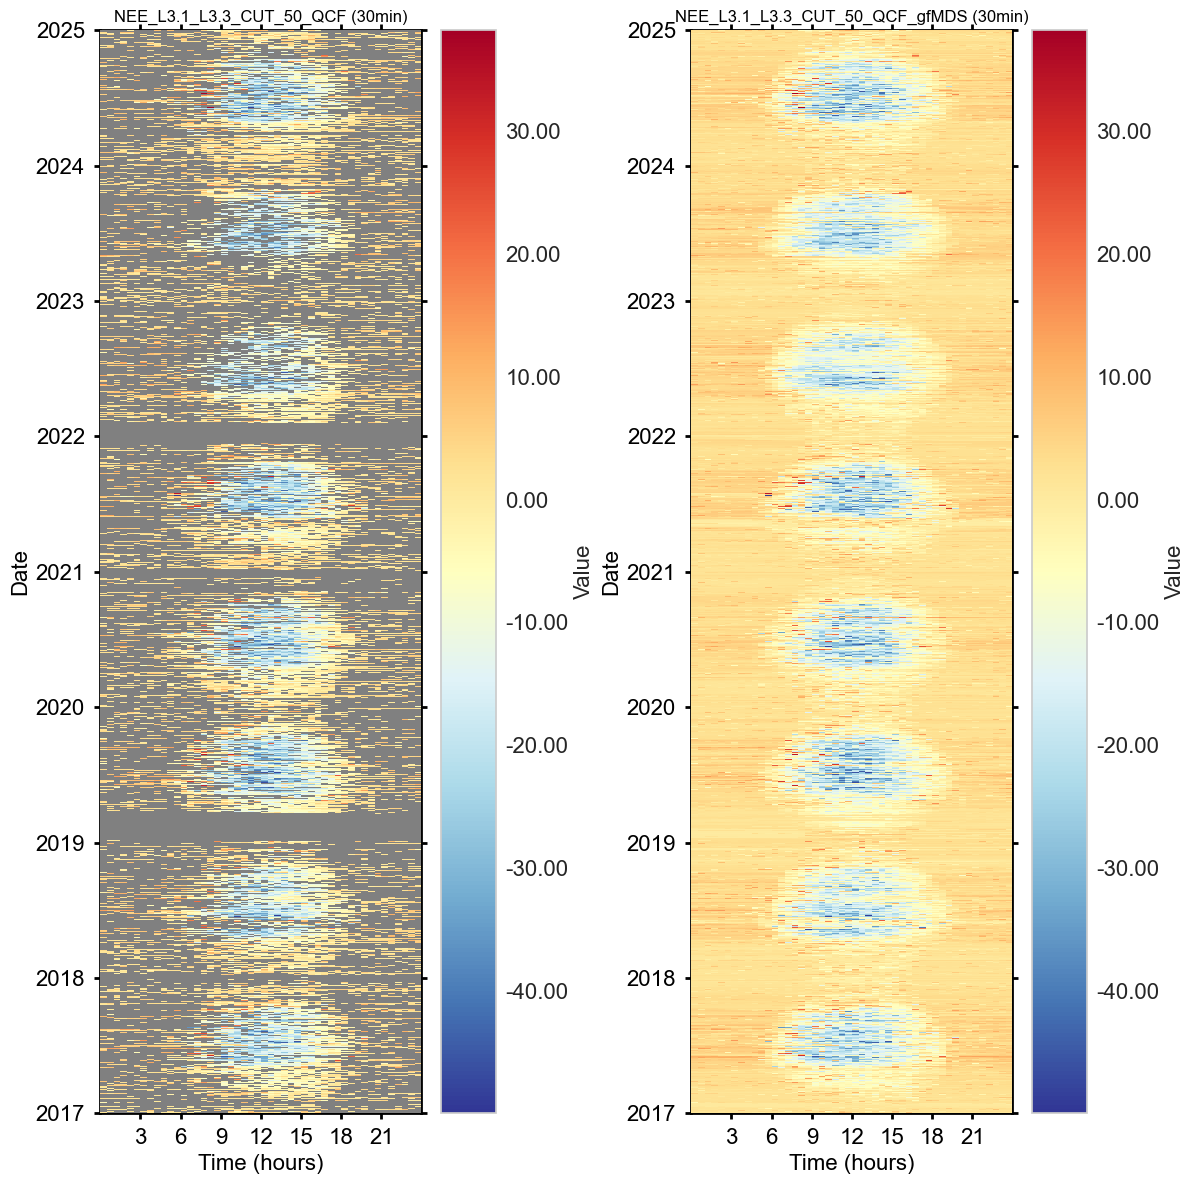

In [125]:
fpc.showplot_gapfilled_heatmap()

## Plot: Gap-filled cumulatives per year

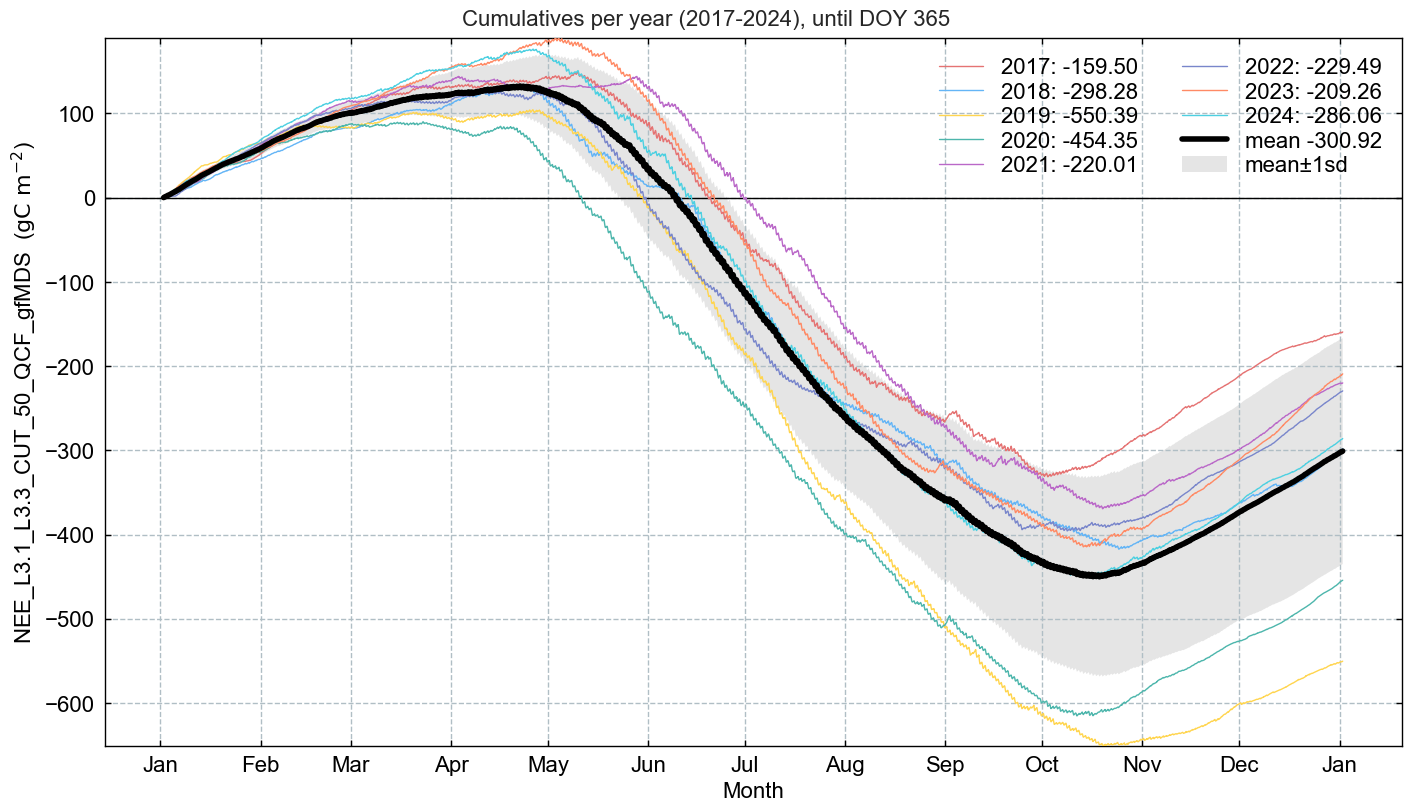

In [126]:
fpc.showplot_gapfilled_cumulative(gain=0.02161926, units=r'($\mathrm{gC\ m^{-2}}$)', per_year=True)

## Plot: gap-filled cumulative across all data 

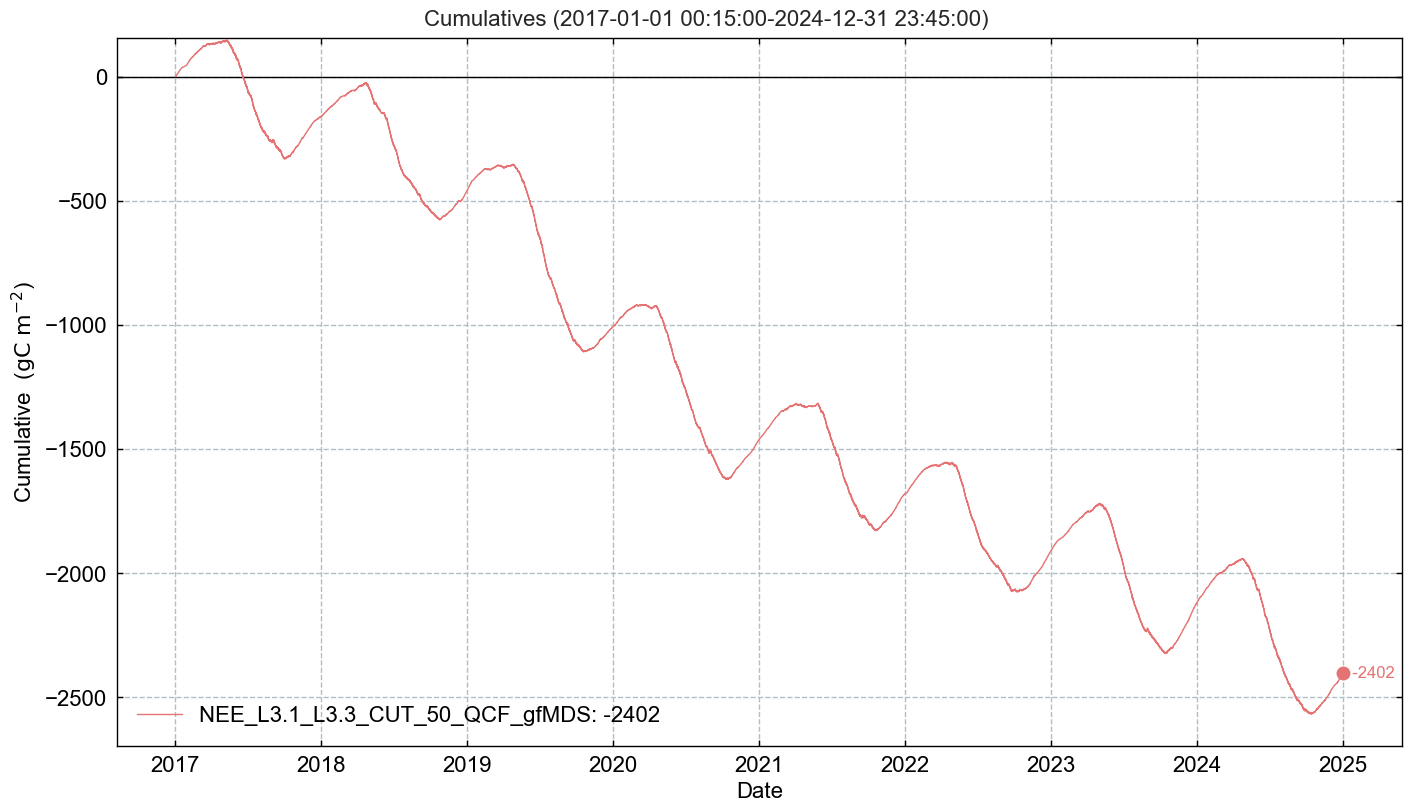

In [127]:
fpc.showplot_gapfilled_cumulative(gain=0.02161926, units=r'($\mathrm{gC\ m^{-2}}$)', per_year=False)

## Plot: model feature ranks per year

In [128]:
fpc.showplot_feature_ranks_per_year()

mds CUT_50 does not have feature ranks.


</br>

</br>

---

# Save results to file

---

- Save results to file for futher processing
- This can be useful if you want to use the data in another software, e.g. continuing post-processing using the library `ReddyProc` in `R` 
- `Parquet` format is recommended for large datasets

</br>

In [129]:
suffix = "NEE"

</br>

## Option 1: Save complete data (input data and results)

In [130]:
# outfile = f"FluxProcessingChain_L4.1_complete_{suffix}"
# results.to_csv(f"{outfile}.csv")  # large file, slow to read
# save_parquet(data=results, filename=f"{outfile}")  # Smaller file, very fast to read

</br>

## Option 2: Save flux processing chain results (without input data)
- Needed if you want to continue post-processing in notebooks
- Can also be used in `R` with the `arrow` package

In [131]:
outfile = f"09.1_L0_FluxProcessingChain_L4.1_{suffix}"
fpc.fpc_df.to_csv(f"{outfile}.csv")  # large file, slow to read
save_parquet(data=fpc.fpc_df, filename=f"{outfile}")  # Smaller file, very fast to read

Saved file 09.1_L0_FluxProcessingChain_L4.1_NEE.parquet (0.144 seconds).


'09.1_L0_FluxProcessingChain_L4.1_NEE.parquet'

</br>

</br>

---

# **End of notebook**

---

Congratulations, you reached the end of this notebook! Before you go let's store your finish time.

In [132]:
dt_string = datetime.now().strftime("%Y-%m-%d %H:%M:%S")
print(f"Finished. {dt_string}")

Finished. 2025-06-12 11:13:51
